In [2]:
# ライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [17]:
# バージョンの確認
import matplotlib
import sklearn
import lightgbm as lgb
print(pd.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(sns.__version__)
print(sklearn.__version__)
print(lgb.__version__)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


2.1.4
1.26.4
3.7.1
0.13.1
1.3.2
4.5.0


In [3]:
# データ読み込み、外れ値の除外

# データセットの読み込み
df = sns.load_dataset('diamonds')

# 外れ値除外の前処理
df = df.drop(df[(df['x'] == 0) | (df['y'] == 0)| (df['z'] == 0)].index, axis=0)
df = df.drop(df[(df['x'] >= 10) | (df['y'] >= 10) | (df['z'] >= 10)].index, axis=0)
df.reset_index(inplace=True, drop=True)
print(df.shape)
df.head()

(53911, 10)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
# 特徴量と目的変数の設定
X = df.drop(['price'], axis=1)
y = df['price']

In [5]:
# 数値×数値の特徴量エンジニアリング

# 密度（重さ/体積）
X['density'] = X['carat'] / (X['x'] * X['y'] * X['z'])

# 差分
X['x-y'] = (X['x'] - X['y']).abs()
X['y-z'] = (X['y'] - X['z']).abs()
X['z-x'] = (X['x'] - X['y']).abs()

# 比率
X['x/y'] = X['x'] / X['y']
X['y/z'] = X['y'] / X['z']
X['z/x'] = X['z'] / X['x']

# 中央値との差分
X['x-median_x'] = (X['x'] - X['x'].median()).abs()
X['y-median_y'] = (X['y'] - X['y'].median()).abs()
X['z-median_z'] = (X['z'] - X['z'].median()).abs()

print('追加した特徴量')
display(X.head())

追加した特徴量


,carat,cut,color,clarity,depth,table,x,y,z,density,x-y,y-z,z-x,x/y,y/z,z/x,x-median_x,y-median_y,z-median_z
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,0.006021,0.03,1.55,0.03,0.992462,1.637860,0.615190,1.75,1.73,1.10
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,0.006086,0.05,1.53,0.05,1.013021,1.662338,0.593830,1.81,1.87,1.22
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,0.006040,0.02,1.76,0.02,0.995086,1.761905,0.570370,1.65,1.64,1.22
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,0.006207,0.03,1.60,0.03,0.992908,1.608365,0.626190,1.50,1.48,0.90
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,0.005971,0.01,1.60,0.01,0.997701,1.581818,0.633641,1.36,1.36,0.78


In [6]:
# カテゴリ変数×数値の特徴量エンジニアリング

# カテゴリ変数cutごとにcarat中央値を集計
X_carat_by_cut = X.groupby('cut')['carat'].agg('median').reset_index()
X_carat_by_cut.columns = ['cut', 'median_carat_by_cut']
print('cutごとにcarat中央値を集計')
display(X_carat_by_cut)
X = pd.merge(X, X_carat_by_cut, on='cut', how = 'left')
X['carat-median_carat_by_cut'] = (X['carat'] - X['median_carat_by_cut'])
X['carat/median_carat_by_cut'] = (X['carat'] / X['median_carat_by_cut'])

# カテゴリ変数colorごとにcarat中央値を集計
X_carat_by_color = X.groupby('color')['carat'].agg('median').reset_index()
X_carat_by_color.columns = ['color', 'median_carat_by_color']
print('colorごとにcarat中央値を集計')
display(X_carat_by_color)
X = pd.merge(X, X_carat_by_color, on='color', how = 'left')
X['carat-median_carat_by_color'] = (X['carat'] - X['median_carat_by_color'])
X['carat/median_carat_by_color'] = (X['carat'] / X['median_carat_by_color'])

# カテゴリ変数clarityごとにcarat中央値を集計
X_carat_by_clarity = X.groupby('clarity')['carat'].agg('median').reset_index()
X_carat_by_clarity.columns = ['clarity', 'median_carat_by_clarity']
print('clarityごとにcarat中央値を集計')
display(X_carat_by_clarity)
X = pd.merge(X, X_carat_by_clarity, on='clarity', how = 'left')
X['carat-median_carat_by_clarity'] = (X['carat'] - X['median_carat_by_clarity'])
X['carat/median_carat_by_clarity'] = (X['carat'] / X ['median_carat_by_clarity'])

display(X.head())

cutごとにcarat中央値を集計


<ipython-input-6-cafc99a029a4>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_carat_by_cut = X.groupby('cut')['carat'].agg('median').reset_index()


,cut,median_carat_by_cut
0,Ideal,0.54
1,Premium,0.85
2,Very Good,0.71
3,Good,0.82
4,Fair,1.00


colorごとにcarat中央値を集計


<ipython-input-6-cafc99a029a4>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_carat_by_color = X.groupby('color')['carat'].agg('median').reset_index()


,color,median_carat_by_color
0,D,0.53
1,E,0.53
2,F,0.70
3,G,0.70
4,H,0.90
5,I,1.00
6,J,1.11


clarityごとにcarat中央値を集計


<ipython-input-6-cafc99a029a4>:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_carat_by_clarity = X.groupby('clarity')['carat'].agg('median').reset_index()


,clarity,median_carat_by_clarity
0,IF,0.35
1,VVS1,0.39
2,VVS2,0.44
3,VS1,0.57
4,VS2,0.63
5,SI1,0.76
6,SI2,1.01
7,I1,1.11


,carat,cut,color,clarity,depth,table,x,y,z,density,...,z-median_z,median_carat_by_cut,carat-median_carat_by_cut,carat/median_carat_by_cut,median_carat_by_color,carat-median_carat_by_color,carat/median_carat_by_color,median_carat_by_clarity,carat-median_carat_by_clarity,carat/median_carat_by_clarity
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,0.006021,...,1.10,0.54,-0.31,0.425926,0.53,-0.30,0.433962,1.01,-0.78,0.227723
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,0.006086,...,1.22,0.85,-0.64,0.247059,0.53,-0.32,0.396226,0.76,-0.55,0.276316
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,0.006040,...,1.22,0.82,-0.59,0.280488,0.53,-0.30,0.433962,0.57,-0.34,0.403509
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,0.006207,...,0.90,0.85,-0.56,0.341176,1.00,-0.71,0.290000,0.63,-0.34,0.460317
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,0.005971,...,0.78,0.82,-0.51,0.378049,1.11,-0.80,0.279279,1.01,-0.70,0.306931


In [7]:
# カテゴリ変数×カテゴリ変数の特徴量エンジニアリング

# cut*colorの出現割合
X_tbl = pd.crosstab(X['cut'], X['color'], normalize='index')
X_tbl = X_tbl.reset_index()
print('cut*colorの出現割合')
display(X_tbl)
X_tbl = pd.melt(X_tbl, id_vars='cut', value_name='rate_cut*color')
X = pd.merge(X, X_tbl, on=['cut', 'color'], how='left' )

# color*clarityの出現割合
X_tbl = pd.crosstab(X['color'], X['clarity'], normalize='index')
X_tbl = X_tbl.reset_index()
print('color*clarityの出現割合')
display(X_tbl)
X_tbl = pd.melt(X_tbl, id_vars='color', value_name='rate_color*clarity')
X = pd.merge(X, X_tbl, on=['color', 'clarity'], how='left' )

# clarity*cutの出現割合
X_tbl = pd.crosstab(X['clarity'], X['cut'], normalize='index')
X_tbl = X_tbl.reset_index()
print('clarity*cutの出現割合')
display(X_tbl)
X_tbl = pd.melt(X_tbl, id_vars='clarity', value_name='rate_clarity*cut')
X = pd.merge(X, X_tbl, on=['clarity', 'cut'], how='left' )

display(X.head())

cut*colorの出現割合


color,cut,D,E,F,G,H,I,J
0,Ideal,0.131526,0.181092,0.177519,0.226574,0.144568,0.097136,0.041584
1,Premium,0.116281,0.169631,0.169122,0.212020,0.170864,0.103506,0.058576
2,Very Good,0.125259,0.198609,0.179154,0.190330,0.150923,0.099594,0.056130
3,Good,0.135047,0.190330,0.185027,0.177275,0.143207,0.106487,0.062627
4,Fair,0.101494,0.139477,0.194271,0.194894,0.188045,0.108966,0.072852


color*clarityの出現割合


clarity,color,IF,VVS1,VVS2,VS1,VS2,SI1,SI2,I1
0,D,0.010776,0.037053,0.081636,0.104074,0.250517,0.307499,0.202244,0.006200
1,E,0.016131,0.066973,0.101174,0.130577,0.252169,0.247677,0.174885,0.010413
2,F,0.040365,0.076955,0.102223,0.143007,0.230761,0.223422,0.168274,0.014993
3,G,0.060351,0.088532,0.127880,0.190269,0.207816,0.175115,0.136920,0.013116
4,H,0.036041,0.070516,0.073288,0.140911,0.197806,0.274108,0.188042,0.019286
5,I,0.026389,0.065510,0.067356,0.177524,0.215722,0.262595,0.168297,0.016608
6,J,0.018182,0.026381,0.046702,0.193226,0.260606,0.267380,0.170766,0.016756


clarity*cutの出現割合


cut,clarity,Ideal,Premium,Very Good,Good,Fair
0,I1,0.199454,0.274590,0.113388,0.129781,0.282787
1,IF,0.677095,0.128492,0.149721,0.039665,0.005028
2,SI1,0.327796,0.273521,0.248029,0.119421,0.031233
3,SI2,0.282774,0.320449,0.228659,0.117378,0.050740
4,VS1,0.439275,0.243511,0.217189,0.079334,0.020690
5,VS2,0.413661,0.273870,0.211360,0.079811,0.021299
6,VVS1,0.560208,0.168309,0.215928,0.050903,0.004652
7,VVS2,0.514410,0.171733,0.243782,0.056455,0.013620


,carat,cut,color,clarity,depth,table,x,y,z,density,...,carat/median_carat_by_cut,median_carat_by_color,carat-median_carat_by_color,carat/median_carat_by_color,median_carat_by_clarity,carat-median_carat_by_clarity,carat/median_carat_by_clarity,rate_cut*color,rate_color*clarity,rate_clarity*cut
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,0.006021,...,0.425926,0.53,-0.30,0.433962,1.01,-0.78,0.227723,0.181092,0.174885,0.282774
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,0.006086,...,0.247059,0.53,-0.32,0.396226,0.76,-0.55,0.276316,0.169631,0.247677,0.273521
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,0.006040,...,0.280488,0.53,-0.30,0.433962,0.57,-0.34,0.403509,0.190330,0.130577,0.079334
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,0.006207,...,0.341176,1.00,-0.71,0.290000,0.63,-0.34,0.460317,0.103506,0.215722,0.273870
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,0.005971,...,0.378049,1.11,-0.80,0.279279,1.01,-0.70,0.306931,0.062627,0.170766,0.117378


In [8]:
# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)

X_trainの形状： (43128, 31)  y_trainの形状： (43128,)  X_testの形状： (10783, 31)  y_testの形状： (10783,)


In [9]:
# カテゴリ変数のlabel encoding
from sklearn.preprocessing import LabelEncoder

cat_cols = ['cut', 'color', 'clarity']

for c in cat_cols:
    le = LabelEncoder()
    le.fit(X_train[c])
    X_train[c] = le.transform(X_train[c])
    X_test[c] = le.transform(X_test[c])

In [10]:
# カテゴリ変数のデータ型をcategoryに変換
cat_cols = ['cut', 'color', 'clarity']

for c in cat_cols:
    X_train[c] = X_train[c].astype('category')
    X_test[c] = X_test[c].astype('category')

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43128 entries, 2640 to 2732
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   carat                          43128 non-null  float64 
 1   cut                            43128 non-null  category
 2   color                          43128 non-null  category
 3   clarity                        43128 non-null  category
 4   depth                          43128 non-null  float64 
 5   table                          43128 non-null  float64 
 6   x                              43128 non-null  float64 
 7   y                              43128 non-null  float64 
 8   z                              43128 non-null  float64 
 9   density                        43128 non-null  float64 
 10  x-y                            43128 non-null  float64 
 11  y-z                            43128 non-null  float64 
 12  z-x                            4312

In [11]:
# 学習データの一部を検証データに分割
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=1)
print('X_trの形状：', X_tr.shape, ' y_trの形状：', y_tr.shape, ' X_vaの形状：', X_va.shape, ' y_vaの形状：', y_va.shape)

X_trの形状： (34502, 31)  y_trの形状： (34502,)  X_vaの形状： (8626, 31)  y_vaの形状： (8626,)


In [12]:
# ライブラリoptunaのインストール
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00


In [13]:
# optunaのバージョン確認
import optuna
optuna.__version__

'4.0.0'

In [16]:
# 固定値のハイパーパラメータ
params_base = {
    'objective': 'mae',
    'random_seed': 1234,
    'learning_rate': 0.02, # 重みの学習率
    'min_data_in_bin': 3, # ヒストグラムのbinの最小レコード数
    'bagging_freq': 1, # baggingを有効化
    'bagging_seed': 0,
    'verbose': -1,
}

In [18]:
# ハイパーパラメータ最適化

# ハイパーパラメータの探索範囲
def objective(trial):
  params_tuning = {
      'num_leaves': trial.suggest_int('num_leaves', 50, 200), # 木の葉数の最大値
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 30), # 葉の作成に必要な最小レコード数
      'max_bin': trial.suggest_int('max_bin', 200, 400), # 特徴量の分割点の計算で使用するヒストグラムのbinの件数の最大値
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.8, 0.95), # 1回のブースティングで使用するレコード数の比率
      'feature_fraction': trial.suggest_float('feature_fraction', 0.35, 0.65), # 1回のブースティングで使用する特徴量数の比率
      'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.01, 1, log=True), #
      'lambda_l1': trial.suggest_float('lambda_l1', 0.01, 1, log=True), # L1正則化の強さ
      'lambda_l2': trial.suggest_float('lambda_l2', 0.01, 1, log=True), # L2正則化の強さ
  }

  # 探索用ハイパーパラメータの設定
  params_tuning.update(params_base)

  lgb_train = lgb.Dataset(X_tr, y_tr)
  lgb_eval = lgb.Dataset(X_va, y_va)

  # 探索用ハイパーパラメータで学習
  model = lgb.train(params_tuning,
                    lgb_train,
                    num_boost_round=10000,
                    valid_sets=[lgb_train, lgb_eval],
                    valid_names=['train', 'valid'],
                    callbacks=[lgb.early_stopping(100),
                               lgb.log_evaluation(500)])

  y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
  score =  mean_absolute_error(y_va, y_va_pred)
  print('')

  return score

In [19]:
# ハイパーパラメータ最適化の実行
import optuna

study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=0), direction='minimize')
study.optimize(objective, n_trials=200)

[I 2024-09-22 17:48:11,213] A new study created in memory with name: no-name-0a1b1739-7118-4f69-8f92-47b206f06403


Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.009	valid's l1: 241.969
[1000]	train's l1: 188.285	valid's l1: 239.083
[1500]	train's l1: 174.648	valid's l1: 238.329
[2000]	train's l1: 164.686	valid's l1: 237.945
Early stopping, best iteration is:
[1936]	train's l1: 165.705	valid's l1: 237.902


[I 2024-09-22 17:48:45,265] Trial 0 finished with value: 237.90199720387386 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 22, 'max_bin': 321, 'bagging_fraction': 0.8817324774495345, 'feature_fraction': 0.4770964398016714, 'min_gain_to_split': 0.19578897201213002, 'lambda_l1': 0.07501954443620121, 'lambda_l2': 0.6074996073425692}. Best is trial 0 with value: 237.90199720387386.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 198.081	valid's l1: 239.91
[1000]	train's l1: 166.228	valid's l1: 237.087
[1500]	train's l1: 148.034	valid's l1: 236.3
Early stopping, best iteration is:
[1767]	train's l1: 141.281	valid's l1: 236.043


[I 2024-09-22 17:49:24,219] Trial 1 finished with value: 236.04279778272314 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 13, 'max_bin': 359, 'bagging_fraction': 0.8793342379629356, 'feature_fraction': 0.5204133683281797, 'min_gain_to_split': 0.70989362574059, 'lambda_l1': 0.013869861245357327, 'lambda_l2': 0.014936835544198456}. Best is trial 1 with value: 236.04279778272314.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 238.791	valid's l1: 245.055
[1000]	train's l1: 219.328	valid's l1: 240.619
[1500]	train's l1: 206.827	valid's l1: 239.388
[2000]	train's l1: 197.874	valid's l1: 238.588
[2500]	train's l1: 189.997	valid's l1: 237.99
Early stopping, best iteration is:
[2579]	train's l1: 188.717	valid's l1: 237.874


[I 2024-09-22 17:49:55,319] Trial 2 finished with value: 237.87415843340005 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 26, 'max_bin': 356, 'bagging_fraction': 0.9305018222370228, 'feature_fraction': 0.6435855026698292, 'min_gain_to_split': 0.39656750817710085, 'lambda_l1': 0.08374496868436809, 'lambda_l2': 0.3639639356786389}. Best is trial 1 with value: 236.04279778272314.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 234.106	valid's l1: 242.96
[1000]	train's l1: 212.302	valid's l1: 239.128
[1500]	train's l1: 198.301	valid's l1: 237.992
Early stopping, best iteration is:
[1478]	train's l1: 198.864	valid's l1: 237.918


[I 2024-09-22 17:50:11,732] Trial 3 finished with value: 237.91809022881404 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 20, 'max_bin': 228, 'bagging_fraction': 0.9417003375574375, 'feature_fraction': 0.5065544965250215, 'min_gain_to_split': 0.06750312521595925, 'lambda_l1': 0.0338151426782029, 'lambda_l2': 0.35356346291488117}. Best is trial 1 with value: 236.04279778272314.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 218.352	valid's l1: 240.885
[1000]	train's l1: 193.766	valid's l1: 237.805
[1500]	train's l1: 179.19	valid's l1: 236.929
Early stopping, best iteration is:
[1610]	train's l1: 176.52	valid's l1: 236.751


[I 2024-09-22 17:50:36,301] Trial 4 finished with value: 236.7510295842597 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 18, 'max_bin': 203, 'bagging_fraction': 0.8926453245613816, 'feature_fraction': 0.5336287168167264, 'min_gain_to_split': 0.17134364197119656, 'lambda_l1': 0.7717846862118062, 'lambda_l2': 0.23101522250182369}. Best is trial 1 with value: 236.04279778272314.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 220.617	valid's l1: 241.169
[1000]	train's l1: 194.798	valid's l1: 237.881
[1500]	train's l1: 177.651	valid's l1: 236.665
Early stopping, best iteration is:
[1787]	train's l1: 170.766	valid's l1: 236.219


[I 2024-09-22 17:51:06,136] Trial 5 finished with value: 236.2194390832468 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 14, 'max_bin': 340, 'bagging_fraction': 0.8090338207443906, 'feature_fraction': 0.5500300146337003, 'min_gain_to_split': 0.21941976179005757, 'lambda_l1': 0.02634905974115613, 'lambda_l2': 0.01810725406663109}. Best is trial 1 with value: 236.04279778272314.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 222.179	valid's l1: 242.039
[1000]	train's l1: 195.049	valid's l1: 238.54
[1500]	train's l1: 178.021	valid's l1: 237.447
Early stopping, best iteration is:
[1505]	train's l1: 177.95	valid's l1: 237.431


[I 2024-09-22 17:51:30,482] Trial 6 finished with value: 237.43096630921642 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 12, 'max_bin': 314, 'bagging_fraction': 0.865790227019348, 'feature_fraction': 0.6465121514177679, 'min_gain_to_split': 0.015998881492631498, 'lambda_l1': 0.02616697456085447, 'lambda_l2': 0.021019338091154416}. Best is trial 1 with value: 236.04279778272314.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.189	valid's l1: 242.049
[1000]	train's l1: 180.807	valid's l1: 238.626
[1500]	train's l1: 162.53	valid's l1: 237.525
[2000]	train's l1: 149.565	valid's l1: 237.067
[2500]	train's l1: 140.383	valid's l1: 236.777
Early stopping, best iteration is:
[2654]	train's l1: 137.68	valid's l1: 236.671


[I 2024-09-22 17:52:13,510] Trial 7 finished with value: 236.67143891929712 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 9, 'max_bin': 293, 'bagging_fraction': 0.8366638388002404, 'feature_fraction': 0.3976908750936559, 'min_gain_to_split': 0.016624564693643644, 'lambda_l1': 0.20542778286285945, 'lambda_l2': 0.018895826938026012}. Best is trial 1 with value: 236.04279778272314.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 227.781	valid's l1: 242.237
[1000]	train's l1: 203.48	valid's l1: 238.467
[1500]	train's l1: 187.839	valid's l1: 237.366
[2000]	train's l1: 175.831	valid's l1: 236.471
[2500]	train's l1: 167.682	valid's l1: 235.978
[3000]	train's l1: 158.734	valid's l1: 235.691
Early stopping, best iteration is:
[3151]	train's l1: 156.534	valid's l1: 235.656


[I 2024-09-22 17:52:58,067] Trial 8 finished with value: 235.65561745916793 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 12, 'max_bin': 365, 'bagging_fraction': 0.8145651913689592, 'feature_fraction': 0.6013834722496412, 'min_gain_to_split': 0.015566709318481201, 'lambda_l1': 0.8972612866432508, 'lambda_l2': 0.08655704137361815}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 201.92	valid's l1: 240.134
[1000]	train's l1: 172.686	valid's l1: 237.336
[1500]	train's l1: 155.467	valid's l1: 236.823
[2000]	train's l1: 144.592	valid's l1: 236.522
Early stopping, best iteration is:
[2112]	train's l1: 142.8	valid's l1: 236.489


[I 2024-09-22 17:53:43,840] Trial 9 finished with value: 236.4888765017299 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 19, 'max_bin': 348, 'bagging_fraction': 0.8058781688381481, 'feature_fraction': 0.43484208877292285, 'min_gain_to_split': 0.017393745944806985, 'lambda_l1': 0.0391093317225106, 'lambda_l2': 0.0172764870082179}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 225.572	valid's l1: 242.927
[1000]	train's l1: 197.831	valid's l1: 238.866
[1500]	train's l1: 179.371	valid's l1: 237.692
Early stopping, best iteration is:
[1809]	train's l1: 169.731	valid's l1: 237.122


[I 2024-09-22 17:54:12,100] Trial 10 finished with value: 237.12175450732548 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 3, 'max_bin': 391, 'bagging_fraction': 0.8357161822219233, 'feature_fraction': 0.5842248758067577, 'min_gain_to_split': 0.05360980835049379, 'lambda_l1': 0.5572928896695892, 'lambda_l2': 0.06472055193755138}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 195.319	valid's l1: 240.218
Early stopping, best iteration is:
[892]	train's l1: 167.847	valid's l1: 237.973


[I 2024-09-22 17:54:37,109] Trial 11 finished with value: 237.97306863276623 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 7, 'max_bin': 390, 'bagging_fraction': 0.9096802355740166, 'feature_fraction': 0.5915466403322428, 'min_gain_to_split': 0.90499112277738, 'lambda_l1': 0.010541614913744073, 'lambda_l2': 0.058124160400173014}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 206.887	valid's l1: 239.961
[1000]	train's l1: 175.051	valid's l1: 237.362
[1500]	train's l1: 156.149	valid's l1: 236.87
[2000]	train's l1: 143.154	valid's l1: 236.537
Early stopping, best iteration is:
[2210]	train's l1: 138.594	valid's l1: 236.382


[I 2024-09-22 17:55:16,999] Trial 12 finished with value: 236.38212454906196 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 11, 'max_bin': 268, 'bagging_fraction': 0.8512860328238031, 'feature_fraction': 0.4607500244006538, 'min_gain_to_split': 0.0328616173682592, 'lambda_l1': 0.31211954149297394, 'lambda_l2': 0.1445025316423963}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 200.712	valid's l1: 239.914
[1000]	train's l1: 167.262	valid's l1: 237.564
[1500]	train's l1: 147.279	valid's l1: 236.582
[2000]	train's l1: 132.72	valid's l1: 236.235
Early stopping, best iteration is:
[2066]	train's l1: 131.181	valid's l1: 236.199


[I 2024-09-22 17:56:01,594] Trial 13 finished with value: 236.1990852518481 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 5, 'max_bin': 368, 'bagging_fraction': 0.9044426307401884, 'feature_fraction': 0.5855994130292499, 'min_gain_to_split': 0.9388287242054596, 'lambda_l1': 0.010844293740159572, 'lambda_l2': 0.04439926537109429}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 228.984	valid's l1: 242.08
[1000]	train's l1: 205.514	valid's l1: 238.049
[1500]	train's l1: 190.715	valid's l1: 237.065
[2000]	train's l1: 177.581	valid's l1: 236.315
[2500]	train's l1: 169.322	valid's l1: 236.023
Early stopping, best iteration is:
[2463]	train's l1: 169.964	valid's l1: 235.996


[I 2024-09-22 17:56:32,758] Trial 14 finished with value: 235.99617473006344 and parameters: {'num_leaves': 78, 'min_data_in_leaf': 16, 'max_bin': 286, 'bagging_fraction': 0.8628860074568359, 'feature_fraction': 0.5397785450167522, 'min_gain_to_split': 0.42943856658548824, 'lambda_l1': 0.19359529526377184, 'lambda_l2': 0.033350638031589996}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 232.225	valid's l1: 244.958
[1000]	train's l1: 208.281	valid's l1: 239.757
[1500]	train's l1: 193.231	valid's l1: 238.338
[2000]	train's l1: 182.687	valid's l1: 237.801
[2500]	train's l1: 174.752	valid's l1: 237.306
Early stopping, best iteration is:
[2732]	train's l1: 171.323	valid's l1: 237.187


[I 2024-09-22 17:57:00,438] Trial 15 finished with value: 237.18704395824466 and parameters: {'num_leaves': 77, 'min_data_in_leaf': 16, 'max_bin': 273, 'bagging_fraction': 0.819476021370418, 'feature_fraction': 0.36080515104506394, 'min_gain_to_split': 0.10373252221566119, 'lambda_l1': 0.18289097673470622, 'lambda_l2': 0.10149202583503748}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 239.692	valid's l1: 245.595
[1000]	train's l1: 220.705	valid's l1: 240.557
[1500]	train's l1: 208.419	valid's l1: 238.585
[2000]	train's l1: 199.673	valid's l1: 237.778
[2500]	train's l1: 192.661	valid's l1: 237.237
[3000]	train's l1: 186.436	valid's l1: 236.851
[3500]	train's l1: 181.591	valid's l1: 236.6
Early stopping, best iteration is:
[3715]	train's l1: 179.485	valid's l1: 236.482


[I 2024-09-22 17:57:38,220] Trial 16 finished with value: 236.4820488569499 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 25, 'max_bin': 257, 'bagging_fraction': 0.8568739829848441, 'feature_fraction': 0.6087651018902487, 'min_gain_to_split': 0.3876262713636511, 'lambda_l1': 0.9793529142759247, 'lambda_l2': 0.03616006467893494}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 222.831	valid's l1: 241.236
[1000]	train's l1: 197.372	valid's l1: 238.456
[1500]	train's l1: 182.233	valid's l1: 237.354
[2000]	train's l1: 169.893	valid's l1: 236.811
Early stopping, best iteration is:
[2353]	train's l1: 163.112	valid's l1: 236.47


[I 2024-09-22 17:58:15,011] Trial 17 finished with value: 236.4701264457281 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 16, 'max_bin': 299, 'bagging_fraction': 0.8302959455273252, 'feature_fraction': 0.5704042920791986, 'min_gain_to_split': 0.0310126106429662, 'lambda_l1': 0.43671151056231206, 'lambda_l2': 0.03289661533553797}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 218.834	valid's l1: 241.047
[1000]	train's l1: 194.896	valid's l1: 238.017
[1500]	train's l1: 180.855	valid's l1: 237.084
Early stopping, best iteration is:
[1809]	train's l1: 174.793	valid's l1: 236.851


[I 2024-09-22 17:58:46,870] Trial 18 finished with value: 236.85148461517295 and parameters: {'num_leaves': 116, 'min_data_in_leaf': 29, 'max_bin': 327, 'bagging_fraction': 0.8484115844537069, 'feature_fraction': 0.6145911652032466, 'min_gain_to_split': 0.10535752232713094, 'lambda_l1': 0.15293473617730224, 'lambda_l2': 0.010435734042374887}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 232.662	valid's l1: 242.835
[1000]	train's l1: 210.291	valid's l1: 239.206
[1500]	train's l1: 194.096	valid's l1: 237.891
[2000]	train's l1: 183.631	valid's l1: 237.292
[2500]	train's l1: 173.397	valid's l1: 236.61
Early stopping, best iteration is:
[2502]	train's l1: 173.375	valid's l1: 236.609


[I 2024-09-22 17:59:18,749] Trial 19 finished with value: 236.60864054791233 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 9, 'max_bin': 243, 'bagging_fraction': 0.8013347171732064, 'feature_fraction': 0.5574690097365729, 'min_gain_to_split': 0.010560166273212131, 'lambda_l1': 0.4635923538325232, 'lambda_l2': 0.09461005786730879}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 227.815	valid's l1: 242.352
[1000]	train's l1: 204	valid's l1: 238.802
Early stopping, best iteration is:
[1279]	train's l1: 195.386	valid's l1: 238.155


[I 2024-09-22 17:59:34,982] Trial 20 finished with value: 238.15495271607296 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 22, 'max_bin': 288, 'bagging_fraction': 0.8235030875726516, 'feature_fraction': 0.4872261355544814, 'min_gain_to_split': 0.48086994566392854, 'lambda_l1': 0.25239575188604735, 'lambda_l2': 0.14408199344773032}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.285	valid's l1: 240.728
[1000]	train's l1: 181.419	valid's l1: 237.571
[1500]	train's l1: 165.545	valid's l1: 237.034
[2000]	train's l1: 155.422	valid's l1: 236.743
Early stopping, best iteration is:
[2191]	train's l1: 152.051	valid's l1: 236.654


[I 2024-09-22 18:00:14,381] Trial 21 finished with value: 236.6543912645019 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 13, 'max_bin': 372, 'bagging_fraction': 0.8754994028573676, 'feature_fraction': 0.5188904796381929, 'min_gain_to_split': 0.5666178688900945, 'lambda_l1': 0.11337128605062559, 'lambda_l2': 0.010033309544949355}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 201.774	valid's l1: 240.78
[1000]	train's l1: 172.049	valid's l1: 238.567
[1500]	train's l1: 155.231	valid's l1: 237.513
Early stopping, best iteration is:
[1709]	train's l1: 149.885	valid's l1: 237.273


[I 2024-09-22 18:00:51,783] Trial 22 finished with value: 237.2730166445701 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 15, 'max_bin': 370, 'bagging_fraction': 0.8916797266120838, 'feature_fraction': 0.5299494674011451, 'min_gain_to_split': 0.6762782123011323, 'lambda_l1': 0.06374852356016919, 'lambda_l2': 0.029013676426363686}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 220.102	valid's l1: 241.443
[1000]	train's l1: 192.614	valid's l1: 238.158
[1500]	train's l1: 176.115	valid's l1: 237.599
[2000]	train's l1: 163.354	valid's l1: 236.832
[2500]	train's l1: 152.281	valid's l1: 236.501
Early stopping, best iteration is:
[2659]	train's l1: 149.305	valid's l1: 236.467


[I 2024-09-22 18:01:33,953] Trial 23 finished with value: 236.46684387941366 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 10, 'max_bin': 335, 'bagging_fraction': 0.8645565269601094, 'feature_fraction': 0.5418755071824922, 'min_gain_to_split': 0.2898846225050468, 'lambda_l1': 0.3510988205019131, 'lambda_l2': 0.06053843869232326}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 206.544	valid's l1: 240.836
[1000]	train's l1: 175.077	valid's l1: 237.637
[1500]	train's l1: 156.245	valid's l1: 237.079
Early stopping, best iteration is:
[1471]	train's l1: 158.042	valid's l1: 237.052


[I 2024-09-22 18:02:06,381] Trial 24 finished with value: 237.0520776604677 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 7, 'max_bin': 310, 'bagging_fraction': 0.9190604846590461, 'feature_fraction': 0.6208537366876744, 'min_gain_to_split': 0.28113262269594985, 'lambda_l1': 0.05065521543233122, 'lambda_l2': 0.026302119419792214}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 233.533	valid's l1: 243.128
[1000]	train's l1: 211.393	valid's l1: 239.38
[1500]	train's l1: 196.954	valid's l1: 238.285
[2000]	train's l1: 186.37	valid's l1: 237.511
[2500]	train's l1: 177.559	valid's l1: 236.913
[3000]	train's l1: 171.721	valid's l1: 236.728
[3500]	train's l1: 166.712	valid's l1: 236.52
Early stopping, best iteration is:
[3878]	train's l1: 163.278	valid's l1: 236.217


[I 2024-09-22 18:02:47,162] Trial 25 finished with value: 236.2166087586728 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 18, 'max_bin': 351, 'bagging_fraction': 0.891864681235528, 'feature_fraction': 0.436606247748338, 'min_gain_to_split': 0.15001466374943612, 'lambda_l1': 0.1312175196762029, 'lambda_l2': 0.013924297485022394}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 225.487	valid's l1: 242.918
[1000]	train's l1: 201.04	valid's l1: 239.518
[1500]	train's l1: 185.224	valid's l1: 238.274
[2000]	train's l1: 173.7	valid's l1: 237.921
[2500]	train's l1: 165.249	valid's l1: 237.497
Early stopping, best iteration is:
[2742]	train's l1: 161.953	valid's l1: 237.358


[I 2024-09-22 18:03:24,671] Trial 26 finished with value: 237.35786933287127 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 13, 'max_bin': 396, 'bagging_fraction': 0.8410868672734293, 'feature_fraction': 0.5134930240798171, 'min_gain_to_split': 0.6957347211033131, 'lambda_l1': 0.016062309232733486, 'lambda_l2': 0.045884695553740466}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 198.936	valid's l1: 239.96
[1000]	train's l1: 163.921	valid's l1: 238.078
[1500]	train's l1: 141.267	valid's l1: 237.352
Early stopping, best iteration is:
[1655]	train's l1: 135.766	valid's l1: 237.083


[I 2024-09-22 18:04:04,574] Trial 27 finished with value: 237.08250929493082 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 2, 'max_bin': 284, 'bagging_fraction': 0.8675426045146947, 'feature_fraction': 0.5595100003007656, 'min_gain_to_split': 0.042172835690966616, 'lambda_l1': 0.6456102795658156, 'lambda_l2': 0.0788142444998995}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 216.176	valid's l1: 240.913
[1000]	train's l1: 189.386	valid's l1: 238.151
[1500]	train's l1: 173.496	valid's l1: 237.177
Early stopping, best iteration is:
[1763]	train's l1: 166.912	valid's l1: 236.793


[I 2024-09-22 18:04:34,191] Trial 28 finished with value: 236.79318388963026 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 16, 'max_bin': 307, 'bagging_fraction': 0.8814221801453757, 'feature_fraction': 0.49271662121638965, 'min_gain_to_split': 0.3151094309199207, 'lambda_l1': 0.016446309375618865, 'lambda_l2': 0.12036225613805414}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.71	valid's l1: 240.829
[1000]	train's l1: 187.492	valid's l1: 237.478
[1500]	train's l1: 172.369	valid's l1: 236.608
[2000]	train's l1: 161.583	valid's l1: 236.189
[2500]	train's l1: 153.895	valid's l1: 235.944
Early stopping, best iteration is:
[2673]	train's l1: 151.546	valid's l1: 235.914


[I 2024-09-22 18:05:18,552] Trial 29 finished with value: 235.91365692467656 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 21, 'max_bin': 333, 'bagging_fraction': 0.8157005061959461, 'feature_fraction': 0.46601308343463044, 'min_gain_to_split': 0.07904360573731628, 'lambda_l1': 0.09596184468318775, 'lambda_l2': 0.013469554556527772}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.573	valid's l1: 240.602
[1000]	train's l1: 189.057	valid's l1: 237.387
[1500]	train's l1: 173.623	valid's l1: 236.353
Early stopping, best iteration is:
[1579]	train's l1: 171.662	valid's l1: 236.241


[I 2024-09-22 18:05:45,773] Trial 30 finished with value: 236.24099793606888 and parameters: {'num_leaves': 131, 'min_data_in_leaf': 23, 'max_bin': 326, 'bagging_fraction': 0.815443472429358, 'feature_fraction': 0.46473200009670795, 'min_gain_to_split': 0.07710979563237344, 'lambda_l1': 0.09041928795380509, 'lambda_l2': 0.022766148843651874}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.421	valid's l1: 239.748
[1000]	train's l1: 180.601	valid's l1: 236.765
[1500]	train's l1: 164.148	valid's l1: 236.154
Early stopping, best iteration is:
[1515]	train's l1: 163.696	valid's l1: 236.13


[I 2024-09-22 18:06:14,700] Trial 31 finished with value: 236.12966074472928 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 18, 'max_bin': 361, 'bagging_fraction': 0.8274180775188443, 'feature_fraction': 0.44119461228124274, 'min_gain_to_split': 0.0239789552545694, 'lambda_l1': 0.06899455220876059, 'lambda_l2': 0.01273608899396913}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 230.294	valid's l1: 243.14
[1000]	train's l1: 207.44	valid's l1: 238.891
[1500]	train's l1: 192.298	valid's l1: 237.652
[2000]	train's l1: 181.791	valid's l1: 236.939
[2500]	train's l1: 174.341	valid's l1: 236.789
Early stopping, best iteration is:
[2869]	train's l1: 169.494	valid's l1: 236.578


[I 2024-09-22 18:06:51,094] Trial 32 finished with value: 236.57804227065375 and parameters: {'num_leaves': 76, 'min_data_in_leaf': 21, 'max_bin': 381, 'bagging_fraction': 0.8113577125002743, 'feature_fraction': 0.4747350959691279, 'min_gain_to_split': 0.1256629425495207, 'lambda_l1': 0.2407347115743867, 'lambda_l2': 0.014271293430217113}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 236.496	valid's l1: 244.519
[1000]	train's l1: 215.368	valid's l1: 239.719
[1500]	train's l1: 203.472	valid's l1: 238.448
[2000]	train's l1: 194.323	valid's l1: 237.632
[2500]	train's l1: 187.123	valid's l1: 237.171
[3000]	train's l1: 180.452	valid's l1: 236.803
Early stopping, best iteration is:
[2936]	train's l1: 181.456	valid's l1: 236.759


[I 2024-09-22 18:07:22,476] Trial 33 finished with value: 236.75851917591896 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 24, 'max_bin': 345, 'bagging_fraction': 0.9457128893421756, 'feature_fraction': 0.41258572558751955, 'min_gain_to_split': 0.222326782074729, 'lambda_l1': 0.05596167327683966, 'lambda_l2': 0.22094546046325925}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 219.663	valid's l1: 241.533
[1000]	train's l1: 193.703	valid's l1: 238.06
Early stopping, best iteration is:
[1299]	train's l1: 184.608	valid's l1: 237.346


[I 2024-09-22 18:07:43,713] Trial 34 finished with value: 237.3457700924357 and parameters: {'num_leaves': 113, 'min_data_in_leaf': 27, 'max_bin': 360, 'bagging_fraction': 0.8450918344457371, 'feature_fraction': 0.5039794182925476, 'min_gain_to_split': 0.010503479684929748, 'lambda_l1': 0.08784653317391133, 'lambda_l2': 0.04222546158953629}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.194	valid's l1: 239.989
[1000]	train's l1: 185.15	valid's l1: 237.73
[1500]	train's l1: 168.938	valid's l1: 236.778
Early stopping, best iteration is:
[1451]	train's l1: 170.556	valid's l1: 236.741


[I 2024-09-22 18:08:12,635] Trial 35 finished with value: 236.74068014688683 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 20, 'max_bin': 336, 'bagging_fraction': 0.9318776444492488, 'feature_fraction': 0.5221533919758713, 'min_gain_to_split': 0.07010588258610989, 'lambda_l1': 0.8439348219469331, 'lambda_l2': 0.6480358601192381}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 221.369	valid's l1: 241.204
[1000]	train's l1: 195.651	valid's l1: 237.974
Early stopping, best iteration is:
[1375]	train's l1: 182.894	valid's l1: 237.242


[I 2024-09-22 18:08:35,403] Trial 36 finished with value: 237.24219833357563 and parameters: {'num_leaves': 99, 'min_data_in_leaf': 14, 'max_bin': 382, 'bagging_fraction': 0.8838571269400856, 'feature_fraction': 0.5676218584674619, 'min_gain_to_split': 0.4201189737018469, 'lambda_l1': 0.02020135586864959, 'lambda_l2': 0.025591932574176277}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 207.688	valid's l1: 241.268
[1000]	train's l1: 181.003	valid's l1: 238.63
[1500]	train's l1: 165.099	valid's l1: 237.569
[2000]	train's l1: 153.476	valid's l1: 236.972
Early stopping, best iteration is:
[2241]	train's l1: 149.694	valid's l1: 236.795


[I 2024-09-22 18:09:13,522] Trial 37 finished with value: 236.79478392299725 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 17, 'max_bin': 211, 'bagging_fraction': 0.857973544704926, 'feature_fraction': 0.4850684238251827, 'min_gain_to_split': 0.18773295182506497, 'lambda_l1': 0.040496010425298615, 'lambda_l2': 0.37878163636342677}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 236.03	valid's l1: 245.003
[1000]	train's l1: 212.884	valid's l1: 240.858
[1500]	train's l1: 199.577	valid's l1: 239.519
[2000]	train's l1: 188.377	valid's l1: 238.751
Early stopping, best iteration is:
[2196]	train's l1: 185.258	valid's l1: 238.522


[I 2024-09-22 18:09:41,029] Trial 38 finished with value: 238.52189009015945 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 14, 'max_bin': 320, 'bagging_fraction': 0.8986129162717058, 'feature_fraction': 0.6355090686631634, 'min_gain_to_split': 0.05316584975763165, 'lambda_l1': 0.029746598642597596, 'lambda_l2': 0.01716710674407004}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.159	valid's l1: 241.099
[1000]	train's l1: 186.776	valid's l1: 237.82
[1500]	train's l1: 168.748	valid's l1: 237.171
Early stopping, best iteration is:
[1547]	train's l1: 167.521	valid's l1: 237.029


[I 2024-09-22 18:10:06,522] Trial 39 finished with value: 237.02948057780418 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 11, 'max_bin': 353, 'bagging_fraction': 0.8320358083536873, 'feature_fraction': 0.4530839961448627, 'min_gain_to_split': 0.6885658481308784, 'lambda_l1': 0.6515501617296773, 'lambda_l2': 0.02056814145984198}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 201.543	valid's l1: 240.471
[1000]	train's l1: 172.888	valid's l1: 238.131
[1500]	train's l1: 157.818	valid's l1: 237.431
Early stopping, best iteration is:
[1858]	train's l1: 149.622	valid's l1: 237.232


[I 2024-09-22 18:10:51,922] Trial 40 finished with value: 237.2317184620627 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 20, 'max_bin': 330, 'bagging_fraction': 0.8771355422770301, 'feature_fraction': 0.5402131529856775, 'min_gain_to_split': 0.024796397535378177, 'lambda_l1': 0.16003167935077914, 'lambda_l2': 0.25312333623554106}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 204.96	valid's l1: 239.667
[1000]	train's l1: 175.22	valid's l1: 236.883
[1500]	train's l1: 158.993	valid's l1: 236.172
Early stopping, best iteration is:
[1740]	train's l1: 153.503	valid's l1: 236.109


[I 2024-09-22 18:11:27,653] Trial 41 finished with value: 236.10896450223308 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 18, 'max_bin': 362, 'bagging_fraction': 0.828288864769305, 'feature_fraction': 0.43874058734286636, 'min_gain_to_split': 0.02135770281691728, 'lambda_l1': 0.06626575007954771, 'lambda_l2': 0.011953270004917742}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 200.583	valid's l1: 241.467
[1000]	train's l1: 169.562	valid's l1: 238.58
[1500]	train's l1: 149.291	valid's l1: 237.464
Early stopping, best iteration is:
[1702]	train's l1: 144.253	valid's l1: 237.246


[I 2024-09-22 18:12:00,997] Trial 42 finished with value: 237.2462657012141 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 12, 'max_bin': 380, 'bagging_fraction': 0.8175390494863679, 'feature_fraction': 0.39554492928634577, 'min_gain_to_split': 0.01398805655522236, 'lambda_l1': 0.11078526982049416, 'lambda_l2': 0.013516560473803353}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 206.798	valid's l1: 241.062
[1000]	train's l1: 178.256	valid's l1: 238.005
[1500]	train's l1: 161.903	valid's l1: 237.447
[2000]	train's l1: 151.052	valid's l1: 237.089
Early stopping, best iteration is:
[1900]	train's l1: 153.01	valid's l1: 237.046


[I 2024-09-22 18:12:38,406] Trial 43 finished with value: 237.04647016885679 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 19, 'max_bin': 342, 'bagging_fraction': 0.8107874167674909, 'feature_fraction': 0.4037722337671387, 'min_gain_to_split': 0.02386078105383538, 'lambda_l1': 0.045633491607059984, 'lambda_l2': 0.015863245708581285}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 200.501	valid's l1: 241.063
[1000]	train's l1: 167.694	valid's l1: 238.364
Early stopping, best iteration is:
[1214]	train's l1: 158.697	valid's l1: 237.812


[I 2024-09-22 18:13:05,009] Trial 44 finished with value: 237.8121840924517 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 8, 'max_bin': 366, 'bagging_fraction': 0.8019763628218576, 'feature_fraction': 0.41803355136084613, 'min_gain_to_split': 0.01812936412042274, 'lambda_l1': 0.06954159505743407, 'lambda_l2': 0.010694746285161136}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 205.254	valid's l1: 240.806
[1000]	train's l1: 175.382	valid's l1: 237.909
Early stopping, best iteration is:
[1309]	train's l1: 164.892	valid's l1: 237.488


[I 2024-09-22 18:13:30,829] Trial 45 finished with value: 237.4876968643942 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 17, 'max_bin': 356, 'bagging_fraction': 0.8233450596353301, 'feature_fraction': 0.3783707898650715, 'min_gain_to_split': 0.03892139099115998, 'lambda_l1': 0.02383232230766723, 'lambda_l2': 0.9580770287916975}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 206.79	valid's l1: 240.389
[1000]	train's l1: 177.037	valid's l1: 237.994
[1500]	train's l1: 160.041	valid's l1: 237.085
Early stopping, best iteration is:
[1686]	train's l1: 155.338	valid's l1: 237.003


[I 2024-09-22 18:14:06,632] Trial 46 finished with value: 237.00333114296885 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 15, 'max_bin': 345, 'bagging_fraction': 0.8386948180343542, 'feature_fraction': 0.5015048637004599, 'min_gain_to_split': 0.0144034082586589, 'lambda_l1': 0.012879232138385347, 'lambda_l2': 0.018412595108910083}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 232.295	valid's l1: 242.775
[1000]	train's l1: 209.042	valid's l1: 238.359
[1500]	train's l1: 196.341	valid's l1: 236.974
[2000]	train's l1: 186.852	valid's l1: 236.49
Early stopping, best iteration is:
[2115]	train's l1: 185.214	valid's l1: 236.354


[I 2024-09-22 18:14:31,873] Trial 47 finished with value: 236.3540342359435 and parameters: {'num_leaves': 72, 'min_data_in_leaf': 22, 'max_bin': 319, 'bagging_fraction': 0.8586381345083395, 'feature_fraction': 0.4523690933436573, 'min_gain_to_split': 0.019062000723892178, 'lambda_l1': 0.03599759553560015, 'lambda_l2': 0.012077555890627556}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 226.941	valid's l1: 242.799
[1000]	train's l1: 200.056	valid's l1: 239.124
[1500]	train's l1: 184.041	valid's l1: 237.913
Early stopping, best iteration is:
[1886]	train's l1: 174.111	valid's l1: 237.285


[I 2024-09-22 18:14:55,795] Trial 48 finished with value: 237.28464205096395 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 11, 'max_bin': 274, 'bagging_fraction': 0.8657640541060783, 'feature_fraction': 0.4226408232402487, 'min_gain_to_split': 0.08570536399508226, 'lambda_l1': 0.31524947433563233, 'lambda_l2': 0.02276537286268008}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 218.871	valid's l1: 242.353
[1000]	train's l1: 189.112	valid's l1: 239.208
[1500]	train's l1: 170.267	valid's l1: 238.407
Early stopping, best iteration is:
[1445]	train's l1: 172.227	valid's l1: 238.289


[I 2024-09-22 18:15:21,192] Trial 49 finished with value: 238.28870302794158 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 5, 'max_bin': 304, 'bagging_fraction': 0.9132446737747683, 'feature_fraction': 0.5850477231434984, 'min_gain_to_split': 0.05784242586265783, 'lambda_l1': 0.20899878992862256, 'lambda_l2': 0.04626242777440837}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 198.704	valid's l1: 239.133
[1000]	train's l1: 168.433	valid's l1: 236.832
[1500]	train's l1: 154.022	valid's l1: 236.4
Early stopping, best iteration is:
[1710]	train's l1: 149.738	valid's l1: 236.327


[I 2024-09-22 18:16:03,746] Trial 50 finished with value: 236.32651546816084 and parameters: {'num_leaves': 199, 'min_data_in_leaf': 20, 'max_bin': 399, 'bagging_fraction': 0.8079193043343926, 'feature_fraction': 0.5971706615366871, 'min_gain_to_split': 0.827502472446221, 'lambda_l1': 0.12785101361316722, 'lambda_l2': 0.07343993751060922}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.532	valid's l1: 240.405
[1000]	train's l1: 180.4	valid's l1: 237.75
[1500]	train's l1: 164.266	valid's l1: 237.049
[2000]	train's l1: 153.048	valid's l1: 236.52
Early stopping, best iteration is:
[2132]	train's l1: 150.833	valid's l1: 236.415


[I 2024-09-22 18:16:45,253] Trial 51 finished with value: 236.41500734905017 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 18, 'max_bin': 362, 'bagging_fraction': 0.8260321563773461, 'feature_fraction': 0.4476945751947487, 'min_gain_to_split': 0.024005463168462842, 'lambda_l1': 0.08041229965890319, 'lambda_l2': 0.011797830090729794}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 207.763	valid's l1: 240.912
[1000]	train's l1: 179.665	valid's l1: 238.305
[1500]	train's l1: 164.4	valid's l1: 237.736
[2000]	train's l1: 152.68	valid's l1: 237.387
Early stopping, best iteration is:
[2255]	train's l1: 147.987	valid's l1: 237.285


[I 2024-09-22 18:17:29,462] Trial 52 finished with value: 237.2853255542685 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 18, 'max_bin': 370, 'bagging_fraction': 0.8183004793889923, 'feature_fraction': 0.4761038783639385, 'min_gain_to_split': 0.03024750356851659, 'lambda_l1': 0.058319402422250095, 'lambda_l2': 0.015782079629015663}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.094	valid's l1: 240.982
[1000]	train's l1: 182.841	valid's l1: 238.052
[1500]	train's l1: 167.213	valid's l1: 237.256
Early stopping, best iteration is:
[1731]	train's l1: 161.922	valid's l1: 237.072


[I 2024-09-22 18:18:00,012] Trial 53 finished with value: 237.07240084075917 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 15, 'max_bin': 375, 'bagging_fraction': 0.8279836082973473, 'feature_fraction': 0.46529967640912034, 'min_gain_to_split': 0.012351985116541573, 'lambda_l1': 0.06987933097163028, 'lambda_l2': 0.03599023159557302}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 206.009	valid's l1: 241.065
[1000]	train's l1: 177.393	valid's l1: 238.55
[1500]	train's l1: 160.891	valid's l1: 237.633
Early stopping, best iteration is:
[1697]	train's l1: 156.107	valid's l1: 237.438


[I 2024-09-22 18:18:34,789] Trial 54 finished with value: 237.43762566521502 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 17, 'max_bin': 385, 'bagging_fraction': 0.8328171418163903, 'feature_fraction': 0.43153580995673, 'min_gain_to_split': 0.02060647183179166, 'lambda_l1': 0.42264880834173635, 'lambda_l2': 0.019586846074833308}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.181	valid's l1: 239.785
[1000]	train's l1: 180.659	valid's l1: 236.765
[1500]	train's l1: 163.592	valid's l1: 236.08
Early stopping, best iteration is:
[1403]	train's l1: 166.089	valid's l1: 236.047


[I 2024-09-22 18:19:00,534] Trial 55 finished with value: 236.04693350776992 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 13, 'max_bin': 360, 'bagging_fraction': 0.8418329609434024, 'feature_fraction': 0.44010316449091025, 'min_gain_to_split': 0.5349915306904427, 'lambda_l1': 0.10328831442577009, 'lambda_l2': 0.030622738471299975}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.276	valid's l1: 240.419
[1000]	train's l1: 182.361	valid's l1: 237.689
[1500]	train's l1: 164.967	valid's l1: 236.913
[2000]	train's l1: 151.979	valid's l1: 236.245
Early stopping, best iteration is:
[2190]	train's l1: 147.767	valid's l1: 236.057


[I 2024-09-22 18:19:37,771] Trial 56 finished with value: 236.0572535360816 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 13, 'max_bin': 253, 'bagging_fraction': 0.8519006757125833, 'feature_fraction': 0.5274569716416012, 'min_gain_to_split': 0.5418555335024524, 'lambda_l1': 0.1854206712039874, 'lambda_l2': 0.03083510094490388}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.54	valid's l1: 239.497
[1000]	train's l1: 181.026	valid's l1: 236.689
[1500]	train's l1: 164.774	valid's l1: 235.805
Early stopping, best iteration is:
[1589]	train's l1: 162.223	valid's l1: 235.732


[I 2024-09-22 18:20:05,059] Trial 57 finished with value: 235.7318330657385 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 13, 'max_bin': 251, 'bagging_fraction': 0.8471473939573079, 'feature_fraction': 0.5300170587993217, 'min_gain_to_split': 0.5300290421059312, 'lambda_l1': 0.18946351069277725, 'lambda_l2': 0.030032877203494818}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.54	valid's l1: 240.235
[1000]	train's l1: 182.339	valid's l1: 237.825
[1500]	train's l1: 165.35	valid's l1: 237.11
[2000]	train's l1: 152.058	valid's l1: 236.648
Early stopping, best iteration is:
[1949]	train's l1: 153.444	valid's l1: 236.59


[I 2024-09-22 18:20:37,698] Trial 58 finished with value: 236.58978778442375 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 10, 'max_bin': 231, 'bagging_fraction': 0.8712548309119912, 'feature_fraction': 0.542390306318019, 'min_gain_to_split': 0.374247218413021, 'lambda_l1': 0.24815602387893146, 'lambda_l2': 0.054221111043070196}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.708	valid's l1: 240.391
[1000]	train's l1: 180.296	valid's l1: 237.911
[1500]	train's l1: 164.354	valid's l1: 236.995
Early stopping, best iteration is:
[1714]	train's l1: 158.801	valid's l1: 236.674


[I 2024-09-22 18:21:08,019] Trial 59 finished with value: 236.67387375426895 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 12, 'max_bin': 295, 'bagging_fraction': 0.8441152641634029, 'feature_fraction': 0.5717232594321165, 'min_gain_to_split': 0.9927509630709427, 'lambda_l1': 0.14498480938348507, 'lambda_l2': 0.028296686100386964}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 216.997	valid's l1: 241.881
[1000]	train's l1: 189.307	valid's l1: 238.63
[1500]	train's l1: 173.606	valid's l1: 237.77
[2000]	train's l1: 161.458	valid's l1: 237.128
[2500]	train's l1: 151.303	valid's l1: 236.75
[3000]	train's l1: 144.618	valid's l1: 236.515
Early stopping, best iteration is:
[3112]	train's l1: 143.171	valid's l1: 236.469


[I 2024-09-22 18:21:53,951] Trial 60 finished with value: 236.4685558653458 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 14, 'max_bin': 264, 'bagging_fraction': 0.8501911627727592, 'feature_fraction': 0.5119260900097655, 'min_gain_to_split': 0.4850732609721633, 'lambda_l1': 0.0982757976402259, 'lambda_l2': 0.036970601486864624}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.658	valid's l1: 240.486
[1000]	train's l1: 182.218	valid's l1: 237.986
Early stopping, best iteration is:
[1327]	train's l1: 171.41	valid's l1: 237.156


[I 2024-09-22 18:22:15,282] Trial 61 finished with value: 237.15586038388304 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 13, 'max_bin': 245, 'bagging_fraction': 0.8553997635638749, 'feature_fraction': 0.5237670444312117, 'min_gain_to_split': 0.5697025776579043, 'lambda_l1': 0.2146522499602, 'lambda_l2': 0.030453180313146144}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.402	valid's l1: 240.658
[1000]	train's l1: 186.464	valid's l1: 237.62
[1500]	train's l1: 168.509	valid's l1: 236.536
[2000]	train's l1: 156.25	valid's l1: 236.101
[2500]	train's l1: 145.237	valid's l1: 235.634
Early stopping, best iteration is:
[2438]	train's l1: 146.869	valid's l1: 235.586


[I 2024-09-22 18:22:53,607] Trial 62 finished with value: 235.5863733901623 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 10, 'max_bin': 252, 'bagging_fraction': 0.8629637354036358, 'feature_fraction': 0.5325603755598751, 'min_gain_to_split': 0.6050253979485543, 'lambda_l1': 0.1801302646958788, 'lambda_l2': 0.024347815641672797}. Best is trial 62 with value: 235.5863733901623.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.053	valid's l1: 241.386
[1000]	train's l1: 185.161	valid's l1: 238.337
[1500]	train's l1: 166.32	valid's l1: 237.361
Early stopping, best iteration is:
[1526]	train's l1: 165.669	valid's l1: 237.336


[I 2024-09-22 18:23:18,787] Trial 63 finished with value: 237.3363857223123 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 10, 'max_bin': 228, 'bagging_fraction': 0.8622075659270164, 'feature_fraction': 0.549180838621001, 'min_gain_to_split': 0.34833354481229584, 'lambda_l1': 0.36913055076901485, 'lambda_l2': 0.023056182294801258}. Best is trial 62 with value: 235.5863733901623.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.906	valid's l1: 241.311
[1000]	train's l1: 183.265	valid's l1: 238.277
[1500]	train's l1: 165.918	valid's l1: 237.59
Early stopping, best iteration is:
[1524]	train's l1: 165.098	valid's l1: 237.538


[I 2024-09-22 18:23:43,762] Trial 64 finished with value: 237.5380373600576 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 8, 'max_bin': 238, 'bagging_fraction': 0.8718008478509806, 'feature_fraction': 0.5354712948645517, 'min_gain_to_split': 0.8309665267312248, 'lambda_l1': 0.3035525207088215, 'lambda_l2': 0.0514580717586892}. Best is trial 62 with value: 235.5863733901623.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 217.646	valid's l1: 241.153
[1000]	train's l1: 190.309	valid's l1: 238.618
[1500]	train's l1: 174.28	valid's l1: 237.852
Early stopping, best iteration is:
[1899]	train's l1: 164.106	valid's l1: 237.406


[I 2024-09-22 18:24:21,085] Trial 65 finished with value: 237.40615405447144 and parameters: {'num_leaves': 116, 'min_data_in_leaf': 12, 'max_bin': 281, 'bagging_fraction': 0.8861736806121712, 'feature_fraction': 0.5539069096863452, 'min_gain_to_split': 0.6183581364369032, 'lambda_l1': 0.5105388376479185, 'lambda_l2': 0.03840053210580601}. Best is trial 62 with value: 235.5863733901623.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 228.95	valid's l1: 243.02
[1000]	train's l1: 204.995	valid's l1: 239.019
[1500]	train's l1: 188.753	valid's l1: 237.843
[2000]	train's l1: 173.458	valid's l1: 237.206
Early stopping, best iteration is:
[1935]	train's l1: 175.333	valid's l1: 237.144


[I 2024-09-22 18:24:49,645] Trial 66 finished with value: 237.1442794455394 and parameters: {'num_leaves': 82, 'min_data_in_leaf': 6, 'max_bin': 215, 'bagging_fraction': 0.8421829632931648, 'feature_fraction': 0.4920424216605598, 'min_gain_to_split': 0.44971114946986923, 'lambda_l1': 0.18224361404220116, 'lambda_l2': 0.025460991110620213}. Best is trial 62 with value: 235.5863733901623.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.562	valid's l1: 241.1
[1000]	train's l1: 185.286	valid's l1: 238.374
[1500]	train's l1: 168.292	valid's l1: 237.527
[2000]	train's l1: 155.479	valid's l1: 236.968
[2500]	train's l1: 143.34	valid's l1: 236.689
Early stopping, best iteration is:
[2595]	train's l1: 141.821	valid's l1: 236.625


[I 2024-09-22 18:25:48,234] Trial 67 finished with value: 236.6251121391469 and parameters: {'num_leaves': 125, 'min_data_in_leaf': 9, 'max_bin': 260, 'bagging_fraction': 0.8352598408132454, 'feature_fraction': 0.6017561317308853, 'min_gain_to_split': 0.24151183592353748, 'lambda_l1': 0.11790053996488432, 'lambda_l2': 0.07186548992151222}. Best is trial 62 with value: 235.5863733901623.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.677	valid's l1: 240.278
[1000]	train's l1: 184.672	valid's l1: 237.239
[1500]	train's l1: 167.722	valid's l1: 236.445
Early stopping, best iteration is:
[1568]	train's l1: 166.042	valid's l1: 236.405


[I 2024-09-22 18:26:32,041] Trial 68 finished with value: 236.40521570709564 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 15, 'max_bin': 251, 'bagging_fraction': 0.8621073912922549, 'feature_fraction': 0.5157315270484407, 'min_gain_to_split': 0.8007013284945664, 'lambda_l1': 0.2783593035398613, 'lambda_l2': 0.09235017410256598}. Best is trial 62 with value: 235.5863733901623.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 223.614	valid's l1: 241.413
[1000]	train's l1: 194.546	valid's l1: 237.962
[1500]	train's l1: 179.469	valid's l1: 237.221
[2000]	train's l1: 164.367	valid's l1: 236.764
Early stopping, best iteration is:
[1974]	train's l1: 164.888	valid's l1: 236.72


[I 2024-09-22 18:26:59,853] Trial 69 finished with value: 236.71989030208186 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 11, 'max_bin': 272, 'bagging_fraction': 0.8471219356930976, 'feature_fraction': 0.5728219550698387, 'min_gain_to_split': 0.5133355082698501, 'lambda_l1': 0.1627706326031056, 'lambda_l2': 0.016089848215940145}. Best is trial 62 with value: 235.5863733901623.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 221.061	valid's l1: 241.316
[1000]	train's l1: 194.38	valid's l1: 238.147
[1500]	train's l1: 178.866	valid's l1: 237.151
[2000]	train's l1: 169.12	valid's l1: 236.756
[2500]	train's l1: 160.45	valid's l1: 236.301
Early stopping, best iteration is:
[2627]	train's l1: 157.802	valid's l1: 236.043


[I 2024-09-22 18:27:43,704] Trial 70 finished with value: 236.04321285409813 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 16, 'max_bin': 314, 'bagging_fraction': 0.8873945849411199, 'feature_fraction': 0.6206304692613636, 'min_gain_to_split': 0.25402843250813545, 'lambda_l1': 0.09798218213685939, 'lambda_l2': 0.14130630403630412}. Best is trial 62 with value: 235.5863733901623.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 228.571	valid's l1: 243.327
[1000]	train's l1: 203.116	valid's l1: 239.348
[1500]	train's l1: 189.335	valid's l1: 238.336
[2000]	train's l1: 178.762	valid's l1: 237.692
Early stopping, best iteration is:
[2220]	train's l1: 173.827	valid's l1: 237.514


[I 2024-09-22 18:28:15,456] Trial 71 finished with value: 237.51396351674018 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 16, 'max_bin': 315, 'bagging_fraction': 0.887944448906823, 'feature_fraction': 0.631275098307964, 'min_gain_to_split': 0.2609213077006859, 'lambda_l1': 0.09382868630116653, 'lambda_l2': 0.11853257152244374}. Best is trial 62 with value: 235.5863733901623.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 219.392	valid's l1: 242.204
[1000]	train's l1: 192.598	valid's l1: 239.049
[1500]	train's l1: 173.101	valid's l1: 237.934
Early stopping, best iteration is:
[1566]	train's l1: 171.621	valid's l1: 237.924


[I 2024-09-22 18:28:45,335] Trial 72 finished with value: 237.92420077305434 and parameters: {'num_leaves': 103, 'min_data_in_leaf': 14, 'max_bin': 335, 'bagging_fraction': 0.8811083358860845, 'feature_fraction': 0.6493026604126017, 'min_gain_to_split': 0.335878213892154, 'lambda_l1': 0.13433369789215904, 'lambda_l2': 0.12756027484482196}. Best is trial 62 with value: 235.5863733901623.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 217.801	valid's l1: 241.264
[1000]	train's l1: 188.953	valid's l1: 238.242
[1500]	train's l1: 175.107	valid's l1: 237.507
[2000]	train's l1: 160.535	valid's l1: 236.737
Early stopping, best iteration is:
[1972]	train's l1: 161.366	valid's l1: 236.714


[I 2024-09-22 18:29:19,341] Trial 73 finished with value: 236.71381204411827 and parameters: {'num_leaves': 110, 'min_data_in_leaf': 12, 'max_bin': 302, 'bagging_fraction': 0.8976545529884296, 'feature_fraction': 0.620500522258616, 'min_gain_to_split': 0.14891365203595383, 'lambda_l1': 0.10716217987399551, 'lambda_l2': 0.2212726094763312}. Best is trial 62 with value: 235.5863733901623.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 222.055	valid's l1: 242.714
[1000]	train's l1: 197.716	valid's l1: 239.178
[1500]	train's l1: 183.826	valid's l1: 238.239
Early stopping, best iteration is:
[1751]	train's l1: 178.632	valid's l1: 237.877


[I 2024-09-22 18:29:48,760] Trial 74 finished with value: 237.87651380676743 and parameters: {'num_leaves': 102, 'min_data_in_leaf': 26, 'max_bin': 312, 'bagging_fraction': 0.8692346878718925, 'feature_fraction': 0.6353857716400396, 'min_gain_to_split': 0.3995034647627133, 'lambda_l1': 0.08054130115346955, 'lambda_l2': 0.16867171331774689}. Best is trial 62 with value: 235.5863733901623.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 216.255	valid's l1: 241.346
[1000]	train's l1: 188.644	valid's l1: 238.109
[1500]	train's l1: 172.634	valid's l1: 237.145
[2000]	train's l1: 158.811	valid's l1: 236.661
Early stopping, best iteration is:
[1902]	train's l1: 160.829	valid's l1: 236.633


[I 2024-09-22 18:30:21,403] Trial 75 finished with value: 236.63279434554863 and parameters: {'num_leaves': 121, 'min_data_in_leaf': 13, 'max_bin': 290, 'bagging_fraction': 0.8533061107177914, 'feature_fraction': 0.5623368026924408, 'min_gain_to_split': 0.6223094671124744, 'lambda_l1': 0.9232808128674838, 'lambda_l2': 0.032869409532456116}. Best is trial 62 with value: 235.5863733901623.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 236.356	valid's l1: 244.401
[1000]	train's l1: 214.576	valid's l1: 239.955
[1500]	train's l1: 200.19	valid's l1: 238.435
[2000]	train's l1: 190.668	valid's l1: 237.709
[2500]	train's l1: 183.281	valid's l1: 237.251
[3000]	train's l1: 176.578	valid's l1: 237.045
Early stopping, best iteration is:
[2982]	train's l1: 176.849	valid's l1: 237.014


[I 2024-09-22 18:30:54,381] Trial 76 finished with value: 237.01399377381412 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 16, 'max_bin': 328, 'bagging_fraction': 0.8773040165393845, 'feature_fraction': 0.6087436102700724, 'min_gain_to_split': 0.7341924274638235, 'lambda_l1': 0.17731230534934211, 'lambda_l2': 0.1491437778890044}. Best is trial 62 with value: 235.5863733901623.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.36	valid's l1: 239.679
[1000]	train's l1: 189.974	valid's l1: 237.23
[1500]	train's l1: 176.056	valid's l1: 236.401
Early stopping, best iteration is:
[1537]	train's l1: 175.301	valid's l1: 236.324


[I 2024-09-22 18:31:23,011] Trial 77 finished with value: 236.32446167661132 and parameters: {'num_leaves': 131, 'min_data_in_leaf': 29, 'max_bin': 350, 'bagging_fraction': 0.8732389797884753, 'feature_fraction': 0.5083296941283486, 'min_gain_to_split': 0.45104751043503666, 'lambda_l1': 0.69932112717523, 'lambda_l2': 0.021561604909903755}. Best is trial 62 with value: 235.5863733901623.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 230.854	valid's l1: 242.629
[1000]	train's l1: 207.44	valid's l1: 239.072
[1500]	train's l1: 192.552	valid's l1: 237.772
[2000]	train's l1: 182.197	valid's l1: 237.097
[2500]	train's l1: 172.271	valid's l1: 236.757
Early stopping, best iteration is:
[2792]	train's l1: 168.644	valid's l1: 236.588


[I 2024-09-22 18:31:54,691] Trial 78 finished with value: 236.58800522913597 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 14, 'max_bin': 281, 'bagging_fraction': 0.82201793029943, 'feature_fraction': 0.5338319190500961, 'min_gain_to_split': 0.6158632268517127, 'lambda_l1': 0.14300128146833535, 'lambda_l2': 0.026746246491954864}. Best is trial 62 with value: 235.5863733901623.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 226.37	valid's l1: 242.259
[1000]	train's l1: 199.504	valid's l1: 238.566
[1500]	train's l1: 182.757	valid's l1: 237.619
[2000]	train's l1: 170.594	valid's l1: 237.094
Early stopping, best iteration is:
[2038]	train's l1: 169.439	valid's l1: 236.991


[I 2024-09-22 18:32:21,856] Trial 79 finished with value: 236.9907939656832 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 9, 'max_bin': 356, 'bagging_fraction': 0.8129616842775952, 'feature_fraction': 0.4980969455797437, 'min_gain_to_split': 0.3026220768694418, 'lambda_l1': 0.2188110245537563, 'lambda_l2': 0.014753475680627034}. Best is trial 62 with value: 235.5863733901623.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 232.716	valid's l1: 243.313
[1000]	train's l1: 208.858	valid's l1: 238.752
[1500]	train's l1: 193.709	valid's l1: 237.378
Early stopping, best iteration is:
[1552]	train's l1: 192.379	valid's l1: 237.307


[I 2024-09-22 18:32:42,783] Trial 80 finished with value: 237.3071854694514 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 10, 'max_bin': 375, 'bagging_fraction': 0.8604827095319392, 'feature_fraction': 0.48386529537072565, 'min_gain_to_split': 0.20194946372173128, 'lambda_l1': 0.047286453431083744, 'lambda_l2': 0.2660816676609836}. Best is trial 62 with value: 235.5863733901623.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.401	valid's l1: 240.047
[1000]	train's l1: 178.341	valid's l1: 236.946
[1500]	train's l1: 162.658	valid's l1: 235.988
[2000]	train's l1: 150.055	valid's l1: 235.386
Early stopping, best iteration is:
[2110]	train's l1: 148.166	valid's l1: 235.251


[I 2024-09-22 18:33:17,992] Trial 81 finished with value: 235.25118747721658 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 11, 'max_bin': 252, 'bagging_fraction': 0.8512770551066924, 'feature_fraction': 0.5263625761073133, 'min_gain_to_split': 0.5281498270105139, 'lambda_l1': 0.17832691551854124, 'lambda_l2': 0.03321813844843955}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.339	valid's l1: 241.306
[1000]	train's l1: 181.917	valid's l1: 238.646
[1500]	train's l1: 164.909	valid's l1: 237.893
Early stopping, best iteration is:
[1845]	train's l1: 156.569	valid's l1: 237.699


[I 2024-09-22 18:33:47,109] Trial 82 finished with value: 237.6994293460916 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 12, 'max_bin': 235, 'bagging_fraction': 0.8790273099556482, 'feature_fraction': 0.5468199460134386, 'min_gain_to_split': 0.7369537461805727, 'lambda_l1': 0.12642059488137875, 'lambda_l2': 0.0413293402266149}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.304	valid's l1: 241.423
[1000]	train's l1: 179.067	valid's l1: 238.319
[1500]	train's l1: 161.133	valid's l1: 237.368
[2000]	train's l1: 149.714	valid's l1: 237.022
Early stopping, best iteration is:
[2158]	train's l1: 146.973	valid's l1: 236.897


[I 2024-09-22 18:34:23,284] Trial 83 finished with value: 236.8974793897235 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 11, 'max_bin': 250, 'bagging_fraction': 0.8389569415034077, 'feature_fraction': 0.5210840340540606, 'min_gain_to_split': 0.4188640921513679, 'lambda_l1': 0.1690271939914368, 'lambda_l2': 0.018295774829504896}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.904	valid's l1: 241.34
[1000]	train's l1: 183.222	valid's l1: 238.232
[1500]	train's l1: 165.518	valid's l1: 237.239
[2000]	train's l1: 152.909	valid's l1: 236.63
Early stopping, best iteration is:
[2204]	train's l1: 148.594	valid's l1: 236.587


[I 2024-09-22 18:34:58,263] Trial 84 finished with value: 236.58710205801623 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 13, 'max_bin': 243, 'bagging_fraction': 0.8471210694382835, 'feature_fraction': 0.5814954794331609, 'min_gain_to_split': 0.5293494071928746, 'lambda_l1': 0.26986285053840203, 'lambda_l2': 0.18030981652549338}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 207.792	valid's l1: 240.534
[1000]	train's l1: 179.522	valid's l1: 237.369
[1500]	train's l1: 164.206	valid's l1: 236.693
Early stopping, best iteration is:
[1410]	train's l1: 166.967	valid's l1: 236.642


[I 2024-09-22 18:35:22,140] Trial 85 finished with value: 236.64176737585004 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 15, 'max_bin': 260, 'bagging_fraction': 0.8044755921823351, 'feature_fraction': 0.46766781014709935, 'min_gain_to_split': 0.9189257976562584, 'lambda_l1': 0.3702336589675838, 'lambda_l2': 0.023789294256185867}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.912	valid's l1: 241.551
[1000]	train's l1: 180.428	valid's l1: 238.99
[1500]	train's l1: 162.28	valid's l1: 238.138
[2000]	train's l1: 147.286	valid's l1: 237.509
Early stopping, best iteration is:
[2345]	train's l1: 138.97	valid's l1: 237.187


[I 2024-09-22 18:35:59,324] Trial 86 finished with value: 237.1866019934758 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 8, 'max_bin': 222, 'bagging_fraction': 0.8655631116484689, 'feature_fraction': 0.532386483750514, 'min_gain_to_split': 0.6521502793369147, 'lambda_l1': 0.10246748495708785, 'lambda_l2': 0.08834514097469959}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.763	valid's l1: 241.636
[1000]	train's l1: 186.721	valid's l1: 238.288
[1500]	train's l1: 167.353	valid's l1: 237.207
Early stopping, best iteration is:
[1496]	train's l1: 167.487	valid's l1: 237.164


[I 2024-09-22 18:36:23,023] Trial 87 finished with value: 237.16443626771166 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 11, 'max_bin': 295, 'bagging_fraction': 0.9015594637325506, 'feature_fraction': 0.42771100463864425, 'min_gain_to_split': 0.37145299897516837, 'lambda_l1': 0.1940188914382411, 'lambda_l2': 0.10755235154861308}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 222.727	valid's l1: 241.773
[1000]	train's l1: 198.438	valid's l1: 238.767
[1500]	train's l1: 184.622	valid's l1: 237.875
Early stopping, best iteration is:
[1876]	train's l1: 174.759	valid's l1: 237.306


[I 2024-09-22 18:36:51,967] Trial 88 finished with value: 237.30634073173914 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 17, 'max_bin': 323, 'bagging_fraction': 0.8921104238237471, 'feature_fraction': 0.6238953231840344, 'min_gain_to_split': 0.48002737969924253, 'lambda_l1': 0.03142292961757557, 'lambda_l2': 0.03255638190731664}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.17	valid's l1: 240.123
[1000]	train's l1: 177.999	valid's l1: 237.584
[1500]	train's l1: 159.443	valid's l1: 236.888
Early stopping, best iteration is:
[1608]	train's l1: 156.059	valid's l1: 236.782


[I 2024-09-22 18:37:26,300] Trial 89 finished with value: 236.78248690832356 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 13, 'max_bin': 339, 'bagging_fraction': 0.853414967625264, 'feature_fraction': 0.5396895348904093, 'min_gain_to_split': 0.10962599302517409, 'lambda_l1': 0.5505723211522563, 'lambda_l2': 0.05410858935496955}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.464	valid's l1: 240.434
[1000]	train's l1: 180.669	valid's l1: 237.434
[1500]	train's l1: 163.914	valid's l1: 236.63
[2000]	train's l1: 151.729	valid's l1: 236.027
Early stopping, best iteration is:
[2169]	train's l1: 147.963	valid's l1: 235.789


[I 2024-09-22 18:38:03,559] Trial 90 finished with value: 235.78863501621575 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 16, 'max_bin': 270, 'bagging_fraction': 0.8577451969511901, 'feature_fraction': 0.5029734055550397, 'min_gain_to_split': 0.5608479615868438, 'lambda_l1': 0.05674781860473291, 'lambda_l2': 0.06347452415203585}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.699	valid's l1: 240.893
[1000]	train's l1: 181.174	valid's l1: 238.36
[1500]	train's l1: 164.62	valid's l1: 237.614
Early stopping, best iteration is:
[1851]	train's l1: 155.397	valid's l1: 237.263


[I 2024-09-22 18:38:34,430] Trial 91 finished with value: 237.2629253340327 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 16, 'max_bin': 271, 'bagging_fraction': 0.8582516895582326, 'feature_fraction': 0.5031229989481606, 'min_gain_to_split': 0.784666319882757, 'lambda_l1': 0.01995683867674501, 'lambda_l2': 0.062117042846534964}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.328	valid's l1: 241.276
[1000]	train's l1: 179.71	valid's l1: 238.704
[1500]	train's l1: 163.841	valid's l1: 237.911
Early stopping, best iteration is:
[1615]	train's l1: 160.819	valid's l1: 237.84


[I 2024-09-22 18:39:03,904] Trial 92 finished with value: 237.83992019832007 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 19, 'max_bin': 267, 'bagging_fraction': 0.8674818691098665, 'feature_fraction': 0.49340685192023465, 'min_gain_to_split': 0.5718573167975426, 'lambda_l1': 0.05697189766090949, 'lambda_l2': 0.04727911397703184}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.552	valid's l1: 240.254
[1000]	train's l1: 179.109	valid's l1: 237.692
[1500]	train's l1: 162.571	valid's l1: 236.918
Early stopping, best iteration is:
[1848]	train's l1: 153.922	valid's l1: 236.635


[I 2024-09-22 18:39:38,224] Trial 93 finished with value: 236.6347297120594 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 15, 'max_bin': 246, 'bagging_fraction': 0.8550452505185454, 'feature_fraction': 0.5276615472404642, 'min_gain_to_split': 0.4352333093765888, 'lambda_l1': 0.07639710690363669, 'lambda_l2': 0.07027136205240309}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.712	valid's l1: 239.985
[1000]	train's l1: 180.086	valid's l1: 237.504
[1500]	train's l1: 163.476	valid's l1: 236.781
[2000]	train's l1: 151.368	valid's l1: 236.128
Early stopping, best iteration is:
[1912]	train's l1: 153.227	valid's l1: 236.115


[I 2024-09-22 18:40:11,915] Trial 94 finished with value: 236.11506478147393 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 10, 'max_bin': 257, 'bagging_fraction': 0.8498306684458705, 'feature_fraction': 0.514279525435647, 'min_gain_to_split': 0.1607135567011684, 'lambda_l1': 0.11749211416759518, 'lambda_l2': 0.08303940516126465}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 218.209	valid's l1: 242.01
[1000]	train's l1: 191.236	valid's l1: 239.066
[1500]	train's l1: 175.132	valid's l1: 238.143
[2000]	train's l1: 163.886	valid's l1: 237.79
[2500]	train's l1: 155.413	valid's l1: 237.318
Early stopping, best iteration is:
[2835]	train's l1: 149.677	valid's l1: 237.1


[I 2024-09-22 18:40:56,558] Trial 95 finished with value: 237.09979561461782 and parameters: {'num_leaves': 112, 'min_data_in_leaf': 14, 'max_bin': 280, 'bagging_fraction': 0.874814111343849, 'feature_fraction': 0.6419588054109151, 'min_gain_to_split': 0.5705203747952962, 'lambda_l1': 0.22803809597579075, 'lambda_l2': 0.020340186446400503}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.744	valid's l1: 241.291
[1000]	train's l1: 187.67	valid's l1: 238.504
[1500]	train's l1: 171.99	valid's l1: 237.803
[2000]	train's l1: 161.584	valid's l1: 237.364
[2500]	train's l1: 154.487	valid's l1: 237.219
Early stopping, best iteration is:
[2425]	train's l1: 155.513	valid's l1: 237.188


[I 2024-09-22 18:41:37,418] Trial 96 finished with value: 237.18805208177898 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 21, 'max_bin': 365, 'bagging_fraction': 0.8435367326615376, 'feature_fraction': 0.48251386929074314, 'min_gain_to_split': 0.6877570529393462, 'lambda_l1': 0.088483748419924, 'lambda_l2': 0.1022036818444977}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 204.176	valid's l1: 240.818
[1000]	train's l1: 172.376	valid's l1: 237.831
[1500]	train's l1: 156.866	valid's l1: 237.384
Early stopping, best iteration is:
[1788]	train's l1: 150.042	valid's l1: 237.038


[I 2024-09-22 18:42:11,957] Trial 97 finished with value: 237.03814281120847 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 17, 'max_bin': 277, 'bagging_fraction': 0.8630902091229952, 'feature_fraction': 0.4579882664775358, 'min_gain_to_split': 0.4946565413851269, 'lambda_l1': 0.012496679126547493, 'lambda_l2': 0.03975457712421262}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 204.62	valid's l1: 240.741
[1000]	train's l1: 174.103	valid's l1: 238.454
Early stopping, best iteration is:
[1264]	train's l1: 164.523	valid's l1: 238.062


[I 2024-09-22 18:42:38,762] Trial 98 finished with value: 238.06157743786505 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 12, 'max_bin': 285, 'bagging_fraction': 0.8698398516611817, 'feature_fraction': 0.5556784829203959, 'min_gain_to_split': 0.3301519531271625, 'lambda_l1': 0.04268458945847094, 'lambda_l2': 0.03505961487078832}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.042	valid's l1: 241.326
[1000]	train's l1: 187.865	valid's l1: 238.159
[1500]	train's l1: 172.973	valid's l1: 237.392
Early stopping, best iteration is:
[1645]	train's l1: 169.221	valid's l1: 237.278


[I 2024-09-22 18:43:03,774] Trial 99 finished with value: 237.27771438139268 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 16, 'max_bin': 240, 'bagging_fraction': 0.81488314802709, 'feature_fraction': 0.5076476777773322, 'min_gain_to_split': 0.8744009339722876, 'lambda_l1': 0.1468250605655392, 'lambda_l2': 0.028071504294669196}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 200.147	valid's l1: 240.998
[1000]	train's l1: 168.392	valid's l1: 238.533
[1500]	train's l1: 150.585	valid's l1: 237.426
Early stopping, best iteration is:
[1889]	train's l1: 141.222	valid's l1: 237.057


[I 2024-09-22 18:43:42,234] Trial 100 finished with value: 237.05728910661497 and parameters: {'num_leaves': 194, 'min_data_in_leaf': 14, 'max_bin': 264, 'bagging_fraction': 0.8885204707408462, 'feature_fraction': 0.4978747915982238, 'min_gain_to_split': 0.27137322113691686, 'lambda_l1': 0.025855677490844674, 'lambda_l2': 0.01114435969271821}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.56	valid's l1: 240.554
[1000]	train's l1: 177.862	valid's l1: 237.53
[1500]	train's l1: 160.408	valid's l1: 236.645
[2000]	train's l1: 148.821	valid's l1: 236.167
[2500]	train's l1: 140.486	valid's l1: 235.9
Early stopping, best iteration is:
[2549]	train's l1: 139.804	valid's l1: 235.88


[I 2024-09-22 18:44:24,632] Trial 101 finished with value: 235.8797215616549 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 12, 'max_bin': 253, 'bagging_fraction': 0.8519922034347925, 'feature_fraction': 0.5269068156152181, 'min_gain_to_split': 0.5405619137629442, 'lambda_l1': 0.19373669013571224, 'lambda_l2': 0.030418521819674506}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.29	valid's l1: 240.295
[1000]	train's l1: 179.416	valid's l1: 237.43
[1500]	train's l1: 159.372	valid's l1: 236.784
[2000]	train's l1: 147.43	valid's l1: 236.371
Early stopping, best iteration is:
[2045]	train's l1: 146.565	valid's l1: 236.282


[I 2024-09-22 18:45:00,087] Trial 102 finished with value: 236.2821839205506 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 12, 'max_bin': 256, 'bagging_fraction': 0.8576050572628855, 'feature_fraction': 0.5236153899206727, 'min_gain_to_split': 0.3677646388363566, 'lambda_l1': 0.16206202428265054, 'lambda_l2': 0.024678025539721656}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.182	valid's l1: 240.131
[1000]	train's l1: 176.971	valid's l1: 237.502
[1500]	train's l1: 159.753	valid's l1: 236.705
Early stopping, best iteration is:
[1571]	train's l1: 157.263	valid's l1: 236.637


[I 2024-09-22 18:45:31,552] Trial 103 finished with value: 236.63745042620536 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 9, 'max_bin': 345, 'bagging_fraction': 0.840196062775873, 'feature_fraction': 0.5442086268699333, 'min_gain_to_split': 0.6148741770942948, 'lambda_l1': 0.1994950401113245, 'lambda_l2': 0.04720701678159761}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.006	valid's l1: 240.392
[1000]	train's l1: 179.877	valid's l1: 237.447
Early stopping, best iteration is:
[1350]	train's l1: 167.554	valid's l1: 236.873


[I 2024-09-22 18:45:52,936] Trial 104 finished with value: 236.87269306194014 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 11, 'max_bin': 249, 'bagging_fraction': 0.8358200171889434, 'feature_fraction': 0.5174728601949627, 'min_gain_to_split': 0.7355370889442958, 'lambda_l1': 0.06207578046244117, 'lambda_l2': 0.017286206488037408}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.343	valid's l1: 239.481
[1000]	train's l1: 179.257	valid's l1: 236.974
[1500]	train's l1: 162.529	valid's l1: 236.347
[2000]	train's l1: 150.414	valid's l1: 235.862
[2500]	train's l1: 142.612	valid's l1: 235.676
Early stopping, best iteration is:
[2676]	train's l1: 140.355	valid's l1: 235.585


[I 2024-09-22 18:46:45,286] Trial 105 finished with value: 235.58509195967517 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 13, 'max_bin': 307, 'bagging_fraction': 0.8469264061824185, 'feature_fraction': 0.534464359788046, 'min_gain_to_split': 0.044805372171620554, 'lambda_l1': 0.2365609136207519, 'lambda_l2': 0.013221921950801598}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 228.091	valid's l1: 243.104
[1000]	train's l1: 203.427	valid's l1: 239.549
[1500]	train's l1: 187.355	valid's l1: 238.212
Early stopping, best iteration is:
[1795]	train's l1: 176.902	valid's l1: 237.383


[I 2024-09-22 18:47:09,901] Trial 106 finished with value: 237.3828243643989 and parameters: {'num_leaves': 80, 'min_data_in_leaf': 10, 'max_bin': 315, 'bagging_fraction': 0.846982683681722, 'feature_fraction': 0.5372737434341436, 'min_gain_to_split': 0.04416225397800803, 'lambda_l1': 0.2389528974395838, 'lambda_l2': 0.013247999224467354}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 207.625	valid's l1: 240.344
[1000]	train's l1: 179.047	valid's l1: 237.679
[1500]	train's l1: 161.153	valid's l1: 236.49
Early stopping, best iteration is:
[1713]	train's l1: 156.315	valid's l1: 236.31


[I 2024-09-22 18:47:44,971] Trial 107 finished with value: 236.30950755922623 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 15, 'max_bin': 307, 'bagging_fraction': 0.8838214638411138, 'feature_fraction': 0.5290028472900447, 'min_gain_to_split': 0.06088433492674011, 'lambda_l1': 0.2828147805897192, 'lambda_l2': 0.010043736939599136}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 225.6	valid's l1: 241.851
[1000]	train's l1: 200.887	valid's l1: 238.203
[1500]	train's l1: 186.246	valid's l1: 237.202
[2000]	train's l1: 176.235	valid's l1: 236.769
[2500]	train's l1: 169.226	valid's l1: 236.273
Early stopping, best iteration is:
[2729]	train's l1: 166.002	valid's l1: 236.065


[I 2024-09-22 18:48:23,733] Trial 108 finished with value: 236.0652045119973 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 19, 'max_bin': 331, 'bagging_fraction': 0.860668922802829, 'feature_fraction': 0.5510582490282699, 'min_gain_to_split': 0.08253227941868678, 'lambda_l1': 0.33569556360934755, 'lambda_l2': 0.021746597080858368}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 216.287	valid's l1: 241.212
[1000]	train's l1: 187.047	valid's l1: 238.499
[1500]	train's l1: 170.852	valid's l1: 237.766
Early stopping, best iteration is:
[1763]	train's l1: 162.531	valid's l1: 237.528


[I 2024-09-22 18:48:53,324] Trial 109 finished with value: 237.52753172278102 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 7, 'max_bin': 289, 'bagging_fraction': 0.8521710762963182, 'feature_fraction': 0.5599676367573581, 'min_gain_to_split': 0.029140278455179885, 'lambda_l1': 0.42482760650898466, 'lambda_l2': 0.014146741913536619}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 235.152	valid's l1: 244.475
[1000]	train's l1: 214.012	valid's l1: 239.837
[1500]	train's l1: 200.964	valid's l1: 238.361
[2000]	train's l1: 191.015	valid's l1: 237.557
Early stopping, best iteration is:
[2333]	train's l1: 185.599	valid's l1: 237.037


[I 2024-09-22 18:49:20,397] Trial 110 finished with value: 237.0374155099429 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 24, 'max_bin': 263, 'bagging_fraction': 0.8559994755616934, 'feature_fraction': 0.510107914295786, 'min_gain_to_split': 0.04863517570159742, 'lambda_l1': 0.2561785981631305, 'lambda_l2': 0.019742593415552522}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.688	valid's l1: 240.576
[1000]	train's l1: 183.234	valid's l1: 237.514
[1500]	train's l1: 166.353	valid's l1: 236.593
[2000]	train's l1: 154.031	valid's l1: 236.054
Early stopping, best iteration is:
[1922]	train's l1: 155.747	valid's l1: 236.044


[I 2024-09-22 18:49:52,776] Trial 111 finished with value: 236.04401007915754 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 13, 'max_bin': 255, 'bagging_fraction': 0.83319862081795, 'feature_fraction': 0.5242802235438041, 'min_gain_to_split': 0.11935084339047135, 'lambda_l1': 0.1307429284900733, 'lambda_l2': 0.03386650056527661}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.834	valid's l1: 241.006
[1000]	train's l1: 182.687	valid's l1: 237.719
[1500]	train's l1: 166.785	valid's l1: 236.921
Early stopping, best iteration is:
[1838]	train's l1: 158.696	valid's l1: 236.529


[I 2024-09-22 18:50:26,043] Trial 112 finished with value: 236.5285994560302 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 13, 'max_bin': 299, 'bagging_fraction': 0.820165823163518, 'feature_fraction': 0.5202530663593913, 'min_gain_to_split': 0.12178377801449815, 'lambda_l1': 0.15051131267278212, 'lambda_l2': 0.03413045653441397}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 207.975	valid's l1: 240.396
[1000]	train's l1: 178.241	valid's l1: 237.779
Early stopping, best iteration is:
[1005]	train's l1: 178.003	valid's l1: 237.75


[I 2024-09-22 18:50:44,904] Trial 113 finished with value: 237.7502216391824 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 11, 'max_bin': 267, 'bagging_fraction': 0.8326079462714364, 'feature_fraction': 0.5273772596638148, 'min_gain_to_split': 0.09773269782463233, 'lambda_l1': 0.13473302667273712, 'lambda_l2': 0.015304610329545179}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 231.703	valid's l1: 243.504
[1000]	train's l1: 207.19	valid's l1: 239.175
[1500]	train's l1: 192.561	valid's l1: 237.941
[2000]	train's l1: 182.428	valid's l1: 237.36
[2500]	train's l1: 174.184	valid's l1: 236.989
[3000]	train's l1: 167.635	valid's l1: 236.664
Early stopping, best iteration is:
[3029]	train's l1: 167.277	valid's l1: 236.617


[I 2024-09-22 18:51:19,541] Trial 114 finished with value: 236.616836067515 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 14, 'max_bin': 254, 'bagging_fraction': 0.8080165529432497, 'feature_fraction': 0.5346974401518547, 'min_gain_to_split': 0.17768937018867617, 'lambda_l1': 0.20312060436596577, 'lambda_l2': 0.027014512758581386}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.447	valid's l1: 241.92
[1000]	train's l1: 185.014	valid's l1: 239.34
[1500]	train's l1: 169.008	valid's l1: 238.393
[2000]	train's l1: 156.494	valid's l1: 237.734
Early stopping, best iteration is:
[2029]	train's l1: 155.998	valid's l1: 237.694


[I 2024-09-22 18:51:53,662] Trial 115 finished with value: 237.69437724031857 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 12, 'max_bin': 259, 'bagging_fraction': 0.8450850671811576, 'feature_fraction': 0.5932396963767826, 'min_gain_to_split': 0.13311889438369146, 'lambda_l1': 0.17717744080758333, 'lambda_l2': 0.02959576651237032}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 207.58	valid's l1: 240.28
[1000]	train's l1: 178.732	valid's l1: 237.575
[1500]	train's l1: 162.753	valid's l1: 236.979
[2000]	train's l1: 150.614	valid's l1: 236.568
[2500]	train's l1: 141.257	valid's l1: 236.364
Early stopping, best iteration is:
[2448]	train's l1: 141.974	valid's l1: 236.309


[I 2024-09-22 18:52:40,451] Trial 116 finished with value: 236.3086238115168 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 13, 'max_bin': 247, 'bagging_fraction': 0.8303769374467012, 'feature_fraction': 0.5789424997718633, 'min_gain_to_split': 0.03735004202142248, 'lambda_l1': 0.15435316143226355, 'lambda_l2': 0.016973582684034115}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.773	valid's l1: 241.019
[1000]	train's l1: 187.532	valid's l1: 238.713
[1500]	train's l1: 173.388	valid's l1: 237.915
Early stopping, best iteration is:
[1771]	train's l1: 167.616	valid's l1: 237.522


[I 2024-09-22 18:53:11,112] Trial 117 finished with value: 237.52188206536826 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 28, 'max_bin': 236, 'bagging_fraction': 0.8492849171873282, 'feature_fraction': 0.5441736532648196, 'min_gain_to_split': 0.22078801213755073, 'lambda_l1': 0.12553844305426817, 'lambda_l2': 0.03811130407779947}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 205.876	valid's l1: 241.342
[1000]	train's l1: 177.174	valid's l1: 239.109
[1500]	train's l1: 158.96	valid's l1: 237.948
Early stopping, best iteration is:
[1540]	train's l1: 158.064	valid's l1: 237.914


[I 2024-09-22 18:53:42,994] Trial 118 finished with value: 237.91444500359762 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 15, 'max_bin': 241, 'bagging_fraction': 0.8640906641333121, 'feature_fraction': 0.5658907732436048, 'min_gain_to_split': 0.09805486648570945, 'lambda_l1': 0.18910403881011273, 'lambda_l2': 0.01262105475722534}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 206.387	valid's l1: 241.115
[1000]	train's l1: 175.724	valid's l1: 238.338
Early stopping, best iteration is:
[1104]	train's l1: 171.657	valid's l1: 238.17


[I 2024-09-22 18:54:08,695] Trial 119 finished with value: 238.16957588239967 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 12, 'max_bin': 308, 'bagging_fraction': 0.8372295989406148, 'feature_fraction': 0.6154111676353571, 'min_gain_to_split': 0.01182772875057687, 'lambda_l1': 0.21423604081006448, 'lambda_l2': 0.06675287462718148}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.433	valid's l1: 240.56
[1000]	train's l1: 186.415	valid's l1: 237.293
[1500]	train's l1: 169.797	valid's l1: 236.386
[2000]	train's l1: 156.968	valid's l1: 235.75
Early stopping, best iteration is:
[2341]	train's l1: 149.819	valid's l1: 235.341


[I 2024-09-22 18:54:43,377] Trial 120 finished with value: 235.3411891578747 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 10, 'max_bin': 251, 'bagging_fraction': 0.8262566059448523, 'feature_fraction': 0.505359187092059, 'min_gain_to_split': 0.4502576743069385, 'lambda_l1': 0.11415577738478262, 'lambda_l2': 0.04234108434702727}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.996	valid's l1: 241.604
[1000]	train's l1: 187.591	valid's l1: 239.093
[1500]	train's l1: 166.785	valid's l1: 238.044
[2000]	train's l1: 153.875	valid's l1: 237.553
Early stopping, best iteration is:
[2341]	train's l1: 147.679	valid's l1: 237.299


[I 2024-09-22 18:55:17,804] Trial 121 finished with value: 237.29905410346598 and parameters: {'num_leaves': 124, 'min_data_in_leaf': 10, 'max_bin': 249, 'bagging_fraction': 0.8255388066471261, 'feature_fraction': 0.5156248732443134, 'min_gain_to_split': 0.06920023432469576, 'lambda_l1': 0.11030665053094645, 'lambda_l2': 0.05067773640371591}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.524	valid's l1: 241.26
[1000]	train's l1: 179.4	valid's l1: 238.455
[1500]	train's l1: 162.072	valid's l1: 237.407
Early stopping, best iteration is:
[1645]	train's l1: 158.377	valid's l1: 237.312


[I 2024-09-22 18:55:46,002] Trial 122 finished with value: 237.31183122302522 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 11, 'max_bin': 254, 'bagging_fraction': 0.8158714313414057, 'feature_fraction': 0.4888628562661991, 'min_gain_to_split': 0.45925807744803704, 'lambda_l1': 0.09222220580312415, 'lambda_l2': 0.04343772346673058}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.313	valid's l1: 240.394
[1000]	train's l1: 181.265	valid's l1: 237.565
[1500]	train's l1: 162.846	valid's l1: 236.674
Early stopping, best iteration is:
[1559]	train's l1: 161.205	valid's l1: 236.514


[I 2024-09-22 18:56:13,534] Trial 123 finished with value: 236.51436133872818 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 9, 'max_bin': 263, 'bagging_fraction': 0.821510914999869, 'feature_fraction': 0.5015694983059162, 'min_gain_to_split': 0.4084754960173792, 'lambda_l1': 0.1398138088647455, 'lambda_l2': 0.031985743171996206}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.185	valid's l1: 240.701
[1000]	train's l1: 185.413	valid's l1: 238.097
[1500]	train's l1: 169.682	valid's l1: 237.355
Early stopping, best iteration is:
[1415]	train's l1: 171.919	valid's l1: 237.334


[I 2024-09-22 18:56:36,384] Trial 124 finished with value: 237.3343397665204 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 14, 'max_bin': 275, 'bagging_fraction': 0.8955840747815286, 'feature_fraction': 0.5116038473510096, 'min_gain_to_split': 0.5203916233870264, 'lambda_l1': 0.16208420403661217, 'lambda_l2': 0.042085010598982245}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.997	valid's l1: 241.565
[1000]	train's l1: 186.225	valid's l1: 238.688
[1500]	train's l1: 168.113	valid's l1: 237.894
[2000]	train's l1: 155.735	valid's l1: 237.363
[2500]	train's l1: 142.617	valid's l1: 237.044
Early stopping, best iteration is:
[2484]	train's l1: 142.949	valid's l1: 236.987


[I 2024-09-22 18:57:12,871] Trial 125 finished with value: 236.9873496671622 and parameters: {'num_leaves': 128, 'min_data_in_leaf': 10, 'max_bin': 232, 'bagging_fraction': 0.8603295337111002, 'feature_fraction': 0.5201474491260026, 'min_gain_to_split': 0.586319108057451, 'lambda_l1': 0.11882306033802806, 'lambda_l2': 0.03525285610613522}. Best is trial 81 with value: 235.25118747721658.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.683	valid's l1: 239.534
[1000]	train's l1: 187.717	valid's l1: 236.594
[1500]	train's l1: 170.888	valid's l1: 235.83
[2000]	train's l1: 159.666	valid's l1: 235.185
Early stopping, best iteration is:
[2130]	train's l1: 156.996	valid's l1: 235.07


[I 2024-09-22 18:57:46,074] Trial 126 finished with value: 235.06996234673343 and parameters: {'num_leaves': 122, 'min_data_in_leaf': 13, 'max_bin': 251, 'bagging_fraction': 0.8249915923128474, 'feature_fraction': 0.530207344529309, 'min_gain_to_split': 0.01618553909792597, 'lambda_l1': 0.051605525130884976, 'lambda_l2': 0.07974863029692511}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 218.863	valid's l1: 241.714
[1000]	train's l1: 193.031	valid's l1: 238.099
[1500]	train's l1: 175.968	valid's l1: 236.803
[2000]	train's l1: 165.864	valid's l1: 236.347
[2500]	train's l1: 158.066	valid's l1: 235.984
[3000]	train's l1: 151.795	valid's l1: 235.763
[3500]	train's l1: 146.114	valid's l1: 235.655
Early stopping, best iteration is:
[3761]	train's l1: 143.689	valid's l1: 235.503


[I 2024-09-22 18:58:43,398] Trial 127 finished with value: 235.5029154434468 and parameters: {'num_leaves': 114, 'min_data_in_leaf': 17, 'max_bin': 297, 'bagging_fraction': 0.8180460208103898, 'feature_fraction': 0.5381047996507767, 'min_gain_to_split': 0.01268608480441369, 'lambda_l1': 0.050033653289796205, 'lambda_l2': 0.07731423143934468}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 216.265	valid's l1: 241.317
[1000]	train's l1: 187.351	valid's l1: 238.056
[1500]	train's l1: 170.259	valid's l1: 236.797
Early stopping, best iteration is:
[1492]	train's l1: 170.485	valid's l1: 236.785


[I 2024-09-22 18:59:08,462] Trial 128 finished with value: 236.78463573883315 and parameters: {'num_leaves': 122, 'min_data_in_leaf': 11, 'max_bin': 269, 'bagging_fraction': 0.812725974801094, 'feature_fraction': 0.5318200984595938, 'min_gain_to_split': 0.01606131704775048, 'lambda_l1': 0.04174213136759695, 'lambda_l2': 0.08211051482115479}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 219.174	valid's l1: 241.341
[1000]	train's l1: 192.1	valid's l1: 238.296
[1500]	train's l1: 177.626	valid's l1: 237.518
[2000]	train's l1: 166.902	valid's l1: 237.16
Early stopping, best iteration is:
[2186]	train's l1: 163.751	valid's l1: 237.046


[I 2024-09-22 18:59:44,787] Trial 129 finished with value: 237.04590346484653 and parameters: {'num_leaves': 116, 'min_data_in_leaf': 21, 'max_bin': 293, 'bagging_fraction': 0.8040693720092607, 'feature_fraction': 0.5393216707097772, 'min_gain_to_split': 0.013803943940575733, 'lambda_l1': 0.03424399853499727, 'lambda_l2': 0.05763955737873454}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 216.665	valid's l1: 241.291
[1000]	train's l1: 187.898	valid's l1: 237.78
Early stopping, best iteration is:
[1298]	train's l1: 176.33	valid's l1: 237.09


[I 2024-09-22 19:00:04,201] Trial 130 finished with value: 237.09007882916873 and parameters: {'num_leaves': 119, 'min_data_in_leaf': 8, 'max_bin': 244, 'bagging_fraction': 0.8247923189328132, 'feature_fraction': 0.49598365188270094, 'min_gain_to_split': 0.01006583520982275, 'lambda_l1': 0.0553788950910889, 'lambda_l2': 0.09250449389686533}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 218.575	valid's l1: 241.173
[1000]	train's l1: 192.803	valid's l1: 237.989
Early stopping, best iteration is:
[1368]	train's l1: 180.788	valid's l1: 237.03


[I 2024-09-22 19:00:26,312] Trial 131 finished with value: 237.0304336048352 and parameters: {'num_leaves': 116, 'min_data_in_leaf': 18, 'max_bin': 299, 'bagging_fraction': 0.8096554397189841, 'feature_fraction': 0.5036314168937785, 'min_gain_to_split': 0.019242491448609084, 'lambda_l1': 0.049422936967713764, 'lambda_l2': 0.11930157816709998}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 220.205	valid's l1: 240.842
[1000]	train's l1: 193.303	valid's l1: 237.574
[1500]	train's l1: 177.271	valid's l1: 236.799
Early stopping, best iteration is:
[1652]	train's l1: 173.197	valid's l1: 236.614


[I 2024-09-22 19:00:52,768] Trial 132 finished with value: 236.61415660424095 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 16, 'max_bin': 305, 'bagging_fraction': 0.8505181374448195, 'feature_fraction': 0.5494733437402581, 'min_gain_to_split': 0.014261453890088654, 'lambda_l1': 0.037807771501554774, 'lambda_l2': 0.10551698614123274}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 218.265	valid's l1: 241.552
[1000]	train's l1: 190.398	valid's l1: 238.36
[1500]	train's l1: 173.204	valid's l1: 237.231
[2000]	train's l1: 162.105	valid's l1: 236.727
Early stopping, best iteration is:
[2023]	train's l1: 161.622	valid's l1: 236.7


[I 2024-09-22 19:01:24,256] Trial 133 finished with value: 236.69977817870327 and parameters: {'num_leaves': 113, 'min_data_in_leaf': 12, 'max_bin': 297, 'bagging_fraction': 0.8194691426544497, 'feature_fraction': 0.4727249232881351, 'min_gain_to_split': 0.011534142536302855, 'lambda_l1': 0.07603227145178103, 'lambda_l2': 0.07685086446743451}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 222.445	valid's l1: 242.599
[1000]	train's l1: 197.116	valid's l1: 238.835
[1500]	train's l1: 181.908	valid's l1: 237.79
[2000]	train's l1: 170.235	valid's l1: 237.246
Early stopping, best iteration is:
[2127]	train's l1: 167.83	valid's l1: 237.136


[I 2024-09-22 19:01:57,281] Trial 134 finished with value: 237.1359892074912 and parameters: {'num_leaves': 100, 'min_data_in_leaf': 17, 'max_bin': 320, 'bagging_fraction': 0.8279445140234707, 'feature_fraction': 0.6065536329557966, 'min_gain_to_split': 0.013435219522381532, 'lambda_l1': 0.05338924816979105, 'lambda_l2': 0.06432840419683736}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.418	valid's l1: 240.788
[1000]	train's l1: 187.666	valid's l1: 237.917
[1500]	train's l1: 172.365	valid's l1: 236.746
[2000]	train's l1: 160.322	valid's l1: 236.308
Early stopping, best iteration is:
[2086]	train's l1: 158.685	valid's l1: 236.191


[I 2024-09-22 19:02:31,572] Trial 135 finished with value: 236.19102033938302 and parameters: {'num_leaves': 124, 'min_data_in_leaf': 14, 'max_bin': 286, 'bagging_fraction': 0.8177813608796517, 'feature_fraction': 0.528758703716111, 'min_gain_to_split': 0.5054006290881541, 'lambda_l1': 0.06195384458270222, 'lambda_l2': 0.058877883598931036}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.83	valid's l1: 239.849
[1000]	train's l1: 188.188	valid's l1: 236.867
[1500]	train's l1: 173.372	valid's l1: 235.979
Early stopping, best iteration is:
[1767]	train's l1: 167.681	valid's l1: 235.746


[I 2024-09-22 19:03:02,991] Trial 136 finished with value: 235.74624081998607 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 23, 'max_bin': 312, 'bagging_fraction': 0.8002348754524209, 'feature_fraction': 0.5389675264050697, 'min_gain_to_split': 0.016648334409848087, 'lambda_l1': 0.016953397448603785, 'lambda_l2': 0.08724197686157674}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.997	valid's l1: 240.71
[1000]	train's l1: 189.927	valid's l1: 238.363
[1500]	train's l1: 174.996	valid's l1: 237.381
Early stopping, best iteration is:
[1571]	train's l1: 173.48	valid's l1: 237.308


[I 2024-09-22 19:03:30,026] Trial 137 finished with value: 237.30770633455032 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 23, 'max_bin': 251, 'bagging_fraction': 0.8015678817840258, 'feature_fraction': 0.5363758342027549, 'min_gain_to_split': 0.017882916481737947, 'lambda_l1': 0.015475461001918801, 'lambda_l2': 0.09705090865934464}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.662	valid's l1: 241.212
[1000]	train's l1: 187.454	valid's l1: 237.772
[1500]	train's l1: 172.983	valid's l1: 236.8
Early stopping, best iteration is:
[1773]	train's l1: 166.708	valid's l1: 236.625


[I 2024-09-22 19:04:03,494] Trial 138 finished with value: 236.6252087831289 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 24, 'max_bin': 355, 'bagging_fraction': 0.8674524997646, 'feature_fraction': 0.5457835412071741, 'min_gain_to_split': 0.015648613234466348, 'lambda_l1': 0.013700909140312394, 'lambda_l2': 0.075418938135029}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.374	valid's l1: 241.123
[1000]	train's l1: 188.663	valid's l1: 238.252
[1500]	train's l1: 173.808	valid's l1: 237.415
[2000]	train's l1: 163.607	valid's l1: 236.978
[2500]	train's l1: 156.046	valid's l1: 236.723
Early stopping, best iteration is:
[2468]	train's l1: 156.457	valid's l1: 236.705


[I 2024-09-22 19:04:44,012] Trial 139 finished with value: 236.70531930120734 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 22, 'max_bin': 259, 'bagging_fraction': 0.8055037312871639, 'feature_fraction': 0.5169478783923718, 'min_gain_to_split': 0.02119671763222012, 'lambda_l1': 0.01957843081631584, 'lambda_l2': 0.06929909254921972}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.926	valid's l1: 241.324
[1000]	train's l1: 186.711	valid's l1: 238.235
[1500]	train's l1: 170.305	valid's l1: 237.272
[2000]	train's l1: 158.2	valid's l1: 236.616
[2500]	train's l1: 148.627	valid's l1: 236.339
Early stopping, best iteration is:
[2493]	train's l1: 148.739	valid's l1: 236.313


[I 2024-09-22 19:05:23,764] Trial 140 finished with value: 236.31257733843418 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 13, 'max_bin': 279, 'bagging_fraction': 0.8113162795188589, 'feature_fraction': 0.5082672377687949, 'min_gain_to_split': 0.027348600703502285, 'lambda_l1': 0.01717133621040576, 'lambda_l2': 0.011418039290527971}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 217.442	valid's l1: 241.189
[1000]	train's l1: 193.163	valid's l1: 238.076
[1500]	train's l1: 177.269	valid's l1: 237.145
[2000]	train's l1: 166.779	valid's l1: 236.698
[2500]	train's l1: 158.781	valid's l1: 236.368
Early stopping, best iteration is:
[2514]	train's l1: 158.598	valid's l1: 236.353


[I 2024-09-22 19:06:06,962] Trial 141 finished with value: 236.35278852369427 and parameters: {'num_leaves': 121, 'min_data_in_leaf': 22, 'max_bin': 311, 'bagging_fraction': 0.8002096006677796, 'feature_fraction': 0.5407550399785226, 'min_gain_to_split': 0.012415257487119535, 'lambda_l1': 0.08443802208491048, 'lambda_l2': 0.08557811077562824}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 204.824	valid's l1: 239.993
[1000]	train's l1: 175.692	valid's l1: 237.218
[1500]	train's l1: 160.684	valid's l1: 236.55
Early stopping, best iteration is:
[1504]	train's l1: 160.595	valid's l1: 236.531


[I 2024-09-22 19:06:38,173] Trial 142 finished with value: 236.53117574808215 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 20, 'max_bin': 313, 'bagging_fraction': 0.8234567326949065, 'feature_fraction': 0.5242279621630906, 'min_gain_to_split': 0.035228401074397495, 'lambda_l1': 0.09688387892483635, 'lambda_l2': 0.13120241675741148}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 226.769	valid's l1: 242.604
[1000]	train's l1: 203.134	valid's l1: 239.137
[1500]	train's l1: 189.966	valid's l1: 237.893
[2000]	train's l1: 180.269	valid's l1: 237.334
[2500]	train's l1: 173.09	valid's l1: 236.973
Early stopping, best iteration is:
[2471]	train's l1: 173.456	valid's l1: 236.968


[I 2024-09-22 19:07:11,590] Trial 143 finished with value: 236.96848187494396 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 23, 'max_bin': 302, 'bagging_fraction': 0.814674424306205, 'feature_fraction': 0.5551319780878878, 'min_gain_to_split': 0.015459139834470966, 'lambda_l1': 0.011865422470800665, 'lambda_l2': 0.18170210459592495}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.034	valid's l1: 240.534
[1000]	train's l1: 186.343	valid's l1: 237.333
[1500]	train's l1: 170.102	valid's l1: 236.544
Early stopping, best iteration is:
[1690]	train's l1: 163.939	valid's l1: 236.333


[I 2024-09-22 19:07:40,140] Trial 144 finished with value: 236.3326807510659 and parameters: {'num_leaves': 128, 'min_data_in_leaf': 15, 'max_bin': 324, 'bagging_fraction': 0.8793970366120916, 'feature_fraction': 0.5323650834847486, 'min_gain_to_split': 0.6461172019263028, 'lambda_l1': 0.010506355123551112, 'lambda_l2': 0.1079601531703961}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 240.616	valid's l1: 245.76
[1000]	train's l1: 218.49	valid's l1: 240.391
[1500]	train's l1: 204.432	valid's l1: 238.89
[2000]	train's l1: 193.24	valid's l1: 237.891
[2500]	train's l1: 185.095	valid's l1: 237.39
Early stopping, best iteration is:
[2534]	train's l1: 184.684	valid's l1: 237.35


[I 2024-09-22 19:08:05,687] Trial 145 finished with value: 237.3498305869612 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 12, 'max_bin': 332, 'bagging_fraction': 0.8540031729467824, 'feature_fraction': 0.5275292124258842, 'min_gain_to_split': 0.016742153296338647, 'lambda_l1': 0.0689589000621641, 'lambda_l2': 0.029339229076202365}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 238.106	valid's l1: 244.515
[1000]	train's l1: 216.219	valid's l1: 239.855
[1500]	train's l1: 202.471	valid's l1: 238.482
[2000]	train's l1: 192.739	valid's l1: 237.927
[2500]	train's l1: 185.939	valid's l1: 237.577
Early stopping, best iteration is:
[2486]	train's l1: 186.116	valid's l1: 237.555


[I 2024-09-22 19:08:30,202] Trial 146 finished with value: 237.55544293052816 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 11, 'max_bin': 291, 'bagging_fraction': 0.9285226448083519, 'feature_fraction': 0.5192134100723569, 'min_gain_to_split': 0.7208387118011851, 'lambda_l1': 0.014002680909582973, 'lambda_l2': 0.07999103272705435}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 218.11	valid's l1: 241.064
[1000]	train's l1: 189.933	valid's l1: 238.002
[1500]	train's l1: 174.239	valid's l1: 237.073
[2000]	train's l1: 163.725	valid's l1: 236.643
[2500]	train's l1: 155.72	valid's l1: 236.338
[3000]	train's l1: 149.795	valid's l1: 236.141
Early stopping, best iteration is:
[2901]	train's l1: 150.85	valid's l1: 236.073


[I 2024-09-22 19:09:15,237] Trial 147 finished with value: 236.0731166909619 and parameters: {'num_leaves': 114, 'min_data_in_leaf': 16, 'max_bin': 376, 'bagging_fraction': 0.8731346204395217, 'feature_fraction': 0.5391098952152296, 'min_gain_to_split': 0.5601275578239525, 'lambda_l1': 0.02970668920984661, 'lambda_l2': 0.024561175809156437}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.073	valid's l1: 240.328
[1000]	train's l1: 184.825	valid's l1: 237.653
[1500]	train's l1: 170.066	valid's l1: 236.9
[2000]	train's l1: 160.596	valid's l1: 236.504
[2500]	train's l1: 153.467	valid's l1: 236.339
Early stopping, best iteration is:
[2453]	train's l1: 153.999	valid's l1: 236.307


[I 2024-09-22 19:10:03,528] Trial 148 finished with value: 236.3073598615461 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 25, 'max_bin': 316, 'bagging_fraction': 0.808216804723267, 'feature_fraction': 0.6240362408765292, 'min_gain_to_split': 0.4593912718069741, 'lambda_l1': 0.24182958766665957, 'lambda_l2': 0.09258959798940472}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 220.35	valid's l1: 242.074
[1000]	train's l1: 193.698	valid's l1: 239.087
[1500]	train's l1: 177.694	valid's l1: 238.34
[2000]	train's l1: 166.683	valid's l1: 237.702
[2500]	train's l1: 158.315	valid's l1: 237.423
Early stopping, best iteration is:
[2885]	train's l1: 152.99	valid's l1: 237.209


[I 2024-09-22 19:10:42,866] Trial 149 finished with value: 237.20852475918892 and parameters: {'num_leaves': 109, 'min_data_in_leaf': 13, 'max_bin': 246, 'bagging_fraction': 0.8573450209621101, 'feature_fraction': 0.5483554826862916, 'min_gain_to_split': 0.6616812735648749, 'lambda_l1': 0.17785560846736748, 'lambda_l2': 0.013801831598383345}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 207.993	valid's l1: 240.666
[1000]	train's l1: 178.09	valid's l1: 238.688
[1500]	train's l1: 159.599	valid's l1: 237.805
[2000]	train's l1: 146.015	valid's l1: 237.324
[2500]	train's l1: 135.297	valid's l1: 237
Early stopping, best iteration is:
[2452]	train's l1: 136.094	valid's l1: 236.984


[I 2024-09-22 19:11:24,922] Trial 150 finished with value: 236.98397761016287 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 10, 'max_bin': 240, 'bagging_fraction': 0.8831043578546436, 'feature_fraction': 0.5114539438530379, 'min_gain_to_split': 0.010840211325741726, 'lambda_l1': 0.02286649566758724, 'lambda_l2': 0.03835981037547503}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 229.978	valid's l1: 243.486
[1000]	train's l1: 205.57	valid's l1: 239.484
[1500]	train's l1: 190.989	valid's l1: 238.228
[2000]	train's l1: 180.571	valid's l1: 237.474
[2500]	train's l1: 169.541	valid's l1: 236.997
[3000]	train's l1: 162.784	valid's l1: 236.664
[3500]	train's l1: 157.684	valid's l1: 236.469
Early stopping, best iteration is:
[3637]	train's l1: 156.231	valid's l1: 236.35


[I 2024-09-22 19:12:04,733] Trial 151 finished with value: 236.35000616861825 and parameters: {'num_leaves': 76, 'min_data_in_leaf': 13, 'max_bin': 254, 'bagging_fraction': 0.8300381973653728, 'feature_fraction': 0.5246500493159968, 'min_gain_to_split': 0.012863300213048698, 'lambda_l1': 0.19775133273162593, 'lambda_l2': 0.033194957283299825}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.307	valid's l1: 240.669
[1000]	train's l1: 186.814	valid's l1: 237.809
[1500]	train's l1: 171.475	valid's l1: 236.961
[2000]	train's l1: 161.097	valid's l1: 236.467
Early stopping, best iteration is:
[1984]	train's l1: 161.444	valid's l1: 236.453


[I 2024-09-22 19:12:38,258] Trial 152 finished with value: 236.45325850731749 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 19, 'max_bin': 257, 'bagging_fraction': 0.8345481453729169, 'feature_fraction': 0.5329458792107582, 'min_gain_to_split': 0.06095465175582515, 'lambda_l1': 0.10521039878794135, 'lambda_l2': 0.026517493960994627}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.174	valid's l1: 240.274
[1000]	train's l1: 180.23	valid's l1: 237.982
[1500]	train's l1: 162.122	valid's l1: 237.244
Early stopping, best iteration is:
[1723]	train's l1: 154.263	valid's l1: 237.048


[I 2024-09-22 19:13:07,300] Trial 153 finished with value: 237.04804930455933 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 12, 'max_bin': 250, 'bagging_fraction': 0.821637725029406, 'feature_fraction': 0.5050524614450225, 'min_gain_to_split': 0.39645604931044937, 'lambda_l1': 0.1350449116270056, 'lambda_l2': 0.031818717007721806}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.444	valid's l1: 240.474
[1000]	train's l1: 182.328	valid's l1: 237.633
[1500]	train's l1: 167.345	valid's l1: 237.026
Early stopping, best iteration is:
[1489]	train's l1: 167.625	valid's l1: 236.999


[I 2024-09-22 19:13:33,209] Trial 154 finished with value: 236.99901781047504 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 15, 'max_bin': 265, 'bagging_fraction': 0.8871021253200849, 'feature_fraction': 0.5215214773032966, 'min_gain_to_split': 0.2025418527133572, 'lambda_l1': 0.1695781802113649, 'lambda_l2': 0.04708858795520441}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.895	valid's l1: 240.844
[1000]	train's l1: 183.056	valid's l1: 237.865
[1500]	train's l1: 167.133	valid's l1: 236.615
Early stopping, best iteration is:
[1778]	train's l1: 160.622	valid's l1: 236.333


[I 2024-09-22 19:14:04,833] Trial 155 finished with value: 236.33339528531206 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 17, 'max_bin': 262, 'bagging_fraction': 0.842095516096537, 'feature_fraction': 0.5134830637197686, 'min_gain_to_split': 0.5003614808098402, 'lambda_l1': 0.21693479223473508, 'lambda_l2': 0.040517862160925844}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 220.884	valid's l1: 240.826
[1000]	train's l1: 194.421	valid's l1: 237.412
[1500]	train's l1: 178.496	valid's l1: 236.392
[2000]	train's l1: 165.431	valid's l1: 235.759
Early stopping, best iteration is:
[2055]	train's l1: 164.294	valid's l1: 235.652


[I 2024-09-22 19:14:33,877] Trial 156 finished with value: 235.6524074355193 and parameters: {'num_leaves': 105, 'min_data_in_leaf': 14, 'max_bin': 253, 'bagging_fraction': 0.8466956243020397, 'feature_fraction': 0.5428053038878846, 'min_gain_to_split': 0.09086710437663975, 'lambda_l1': 0.11714784001782466, 'lambda_l2': 0.0288177907870755}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 222.029	valid's l1: 242.322
[1000]	train's l1: 195.918	valid's l1: 239.078
[1500]	train's l1: 180.007	valid's l1: 238.024
Early stopping, best iteration is:
[1599]	train's l1: 177.333	valid's l1: 237.898


[I 2024-09-22 19:14:59,099] Trial 157 finished with value: 237.89789939080208 and parameters: {'num_leaves': 101, 'min_data_in_leaf': 15, 'max_bin': 304, 'bagging_fraction': 0.8465807130834663, 'feature_fraction': 0.5546855660354977, 'min_gain_to_split': 0.09230102639942758, 'lambda_l1': 0.04352411194296699, 'lambda_l2': 0.15075514100189252}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 224.044	valid's l1: 242.153
[1000]	train's l1: 198.935	valid's l1: 239.108
[1500]	train's l1: 181.783	valid's l1: 237.716
[2000]	train's l1: 170.549	valid's l1: 237.178
Early stopping, best iteration is:
[1960]	train's l1: 171.649	valid's l1: 237.153


[I 2024-09-22 19:15:28,784] Trial 158 finished with value: 237.1533634864408 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 14, 'max_bin': 387, 'bagging_fraction': 0.8527101451839628, 'feature_fraction': 0.542843885128471, 'min_gain_to_split': 0.11197183832645574, 'lambda_l1': 0.11463179111975139, 'lambda_l2': 0.028351696274420968}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 221.342	valid's l1: 242.326
[1000]	train's l1: 193.837	valid's l1: 238.431
[1500]	train's l1: 176.578	valid's l1: 237.313
[2000]	train's l1: 163.656	valid's l1: 236.79
[2500]	train's l1: 154.593	valid's l1: 236.403
[3000]	train's l1: 146.009	valid's l1: 236.133
Early stopping, best iteration is:
[3173]	train's l1: 143.946	valid's l1: 236.054


[I 2024-09-22 19:16:08,641] Trial 159 finished with value: 236.05361130302558 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 11, 'max_bin': 318, 'bagging_fraction': 0.8443561081856379, 'feature_fraction': 0.3530083387568447, 'min_gain_to_split': 0.0869137150110879, 'lambda_l1': 0.29510839044641973, 'lambda_l2': 0.018766650713658274}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 220.093	valid's l1: 241.874
[1000]	train's l1: 194.239	valid's l1: 238.485
[1500]	train's l1: 179.407	valid's l1: 237.285
[2000]	train's l1: 167.924	valid's l1: 236.596
Early stopping, best iteration is:
[2005]	train's l1: 167.827	valid's l1: 236.583


[I 2024-09-22 19:16:36,974] Trial 160 finished with value: 236.5831229732468 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 16, 'max_bin': 246, 'bagging_fraction': 0.8498772953068809, 'feature_fraction': 0.5636128965085364, 'min_gain_to_split': 0.5561578183303859, 'lambda_l1': 0.08537082890647744, 'lambda_l2': 0.021693538950225542}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 220.842	valid's l1: 242.186
[1000]	train's l1: 193.662	valid's l1: 239.024
[1500]	train's l1: 177.644	valid's l1: 238.137
[2000]	train's l1: 165.315	valid's l1: 237.866
Early stopping, best iteration is:
[1914]	train's l1: 167.547	valid's l1: 237.796


[I 2024-09-22 19:17:04,177] Trial 161 finished with value: 237.7964635354889 and parameters: {'num_leaves': 105, 'min_data_in_leaf': 13, 'max_bin': 253, 'bagging_fraction': 0.8165603593351082, 'feature_fraction': 0.5352910773198806, 'min_gain_to_split': 0.07880155396906344, 'lambda_l1': 0.15036854224869664, 'lambda_l2': 0.03598350205475878}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 216.234	valid's l1: 241.608
[1000]	train's l1: 189.265	valid's l1: 238.421
[1500]	train's l1: 172.354	valid's l1: 237.273
[2000]	train's l1: 160.06	valid's l1: 236.8
[2500]	train's l1: 151.071	valid's l1: 236.416
Early stopping, best iteration is:
[2547]	train's l1: 150.386	valid's l1: 236.393


[I 2024-09-22 19:17:38,424] Trial 162 finished with value: 236.39339523777383 and parameters: {'num_leaves': 122, 'min_data_in_leaf': 14, 'max_bin': 256, 'bagging_fraction': 0.8380134264920851, 'feature_fraction': 0.5283692765636586, 'min_gain_to_split': 0.785832814423659, 'lambda_l1': 0.12746260410288074, 'lambda_l2': 0.030625156329472387}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.45	valid's l1: 239.765
[1000]	train's l1: 184.346	valid's l1: 236.881
[1500]	train's l1: 168.025	valid's l1: 235.885
[2000]	train's l1: 155.602	valid's l1: 235.487
Early stopping, best iteration is:
[2045]	train's l1: 154.516	valid's l1: 235.441


[I 2024-09-22 19:18:13,260] Trial 163 finished with value: 235.44146124944584 and parameters: {'num_leaves': 131, 'min_data_in_leaf': 12, 'max_bin': 243, 'bagging_fraction': 0.8282709715482919, 'feature_fraction': 0.5376038430874605, 'min_gain_to_split': 0.07226650092148874, 'lambda_l1': 0.09759848704558419, 'lambda_l2': 0.024826072171989583}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.113	valid's l1: 241.358
[1000]	train's l1: 184.524	valid's l1: 238.463
[1500]	train's l1: 167.789	valid's l1: 237.408
Early stopping, best iteration is:
[1802]	train's l1: 158.942	valid's l1: 237.018


[I 2024-09-22 19:18:42,351] Trial 164 finished with value: 237.01792861178856 and parameters: {'num_leaves': 131, 'min_data_in_leaf': 12, 'max_bin': 237, 'bagging_fraction': 0.8255505705035182, 'feature_fraction': 0.5392814568286131, 'min_gain_to_split': 0.06256359461525565, 'lambda_l1': 0.09821990179537352, 'lambda_l2': 0.02271348134589916}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 223.819	valid's l1: 241.636
[1000]	train's l1: 198.225	valid's l1: 238.157
[1500]	train's l1: 183.191	valid's l1: 237.302
[2000]	train's l1: 171.538	valid's l1: 236.633
[2500]	train's l1: 160.167	valid's l1: 236.445
Early stopping, best iteration is:
[2681]	train's l1: 157.496	valid's l1: 236.29


[I 2024-09-22 19:19:18,460] Trial 165 finished with value: 236.29010490706284 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 11, 'max_bin': 249, 'bagging_fraction': 0.8559232710779688, 'feature_fraction': 0.5334271880771643, 'min_gain_to_split': 0.07114905279154381, 'lambda_l1': 0.07743686484006201, 'lambda_l2': 0.02543239876662112}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.679	valid's l1: 240.287
[1000]	train's l1: 186.317	valid's l1: 237.359
[1500]	train's l1: 170.589	valid's l1: 236.564
[2000]	train's l1: 157.438	valid's l1: 236.116
Early stopping, best iteration is:
[2030]	train's l1: 156.837	valid's l1: 236.054


[I 2024-09-22 19:19:55,981] Trial 166 finished with value: 236.0540926728984 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 14, 'max_bin': 367, 'bagging_fraction': 0.8595730504515842, 'feature_fraction': 0.5480592824938109, 'min_gain_to_split': 0.0734573805298743, 'lambda_l1': 0.8217295597207314, 'lambda_l2': 0.07272043761485406}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 217.174	valid's l1: 240.999
[1000]	train's l1: 189.445	valid's l1: 237.661
[1500]	train's l1: 172.532	valid's l1: 237.032
[2000]	train's l1: 160.028	valid's l1: 236.681
Early stopping, best iteration is:
[2231]	train's l1: 154.004	valid's l1: 236.53


[I 2024-09-22 19:20:28,830] Trial 167 finished with value: 236.5302466697836 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 12, 'max_bin': 243, 'bagging_fraction': 0.8198174191435708, 'feature_fraction': 0.5184240594234303, 'min_gain_to_split': 0.05252347428256975, 'lambda_l1': 0.1846852448474562, 'lambda_l2': 0.015441901690665944}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.064	valid's l1: 241.834
[1000]	train's l1: 182.986	valid's l1: 238.413
[1500]	train's l1: 168.244	valid's l1: 237.76
Early stopping, best iteration is:
[1608]	train's l1: 165.818	valid's l1: 237.615


[I 2024-09-22 19:20:59,060] Trial 168 finished with value: 237.61461444129952 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 17, 'max_bin': 310, 'bagging_fraction': 0.8469934698571903, 'feature_fraction': 0.6304740955465086, 'min_gain_to_split': 0.6134906897781759, 'lambda_l1': 0.22477523174854988, 'lambda_l2': 0.0877377742894861}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.153	valid's l1: 240.583
[1000]	train's l1: 185.071	valid's l1: 237.472
[1500]	train's l1: 168.257	valid's l1: 236.516
Early stopping, best iteration is:
[1566]	train's l1: 166.725	valid's l1: 236.45


[I 2024-09-22 19:21:24,762] Trial 169 finished with value: 236.45031875838777 and parameters: {'num_leaves': 128, 'min_data_in_leaf': 9, 'max_bin': 223, 'bagging_fraction': 0.84024793125487, 'feature_fraction': 0.5441345674016023, 'min_gain_to_split': 0.08961388024674495, 'lambda_l1': 0.04973710890138019, 'lambda_l2': 0.012988933851151229}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 228.316	valid's l1: 242.685
[1000]	train's l1: 204.428	valid's l1: 238.836
[1500]	train's l1: 190.41	valid's l1: 237.968
[2000]	train's l1: 178.745	valid's l1: 237.389
[2500]	train's l1: 168.708	valid's l1: 236.96
Early stopping, best iteration is:
[2814]	train's l1: 164.081	valid's l1: 236.738


[I 2024-09-22 19:21:58,884] Trial 170 finished with value: 236.7382981836699 and parameters: {'num_leaves': 81, 'min_data_in_leaf': 13, 'max_bin': 271, 'bagging_fraction': 0.8654270518028424, 'feature_fraction': 0.5278605887508248, 'min_gain_to_split': 0.019052601174661937, 'lambda_l1': 0.10731197899578271, 'lambda_l2': 0.11162250287019285}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.412	valid's l1: 241.43
[1000]	train's l1: 186.406	valid's l1: 238.529
[1500]	train's l1: 166.493	valid's l1: 237.399
[2000]	train's l1: 154.733	valid's l1: 236.895
Early stopping, best iteration is:
[1997]	train's l1: 154.823	valid's l1: 236.887


[I 2024-09-22 19:22:29,342] Trial 171 finished with value: 236.88720635968428 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 13, 'max_bin': 252, 'bagging_fraction': 0.8301422788412935, 'feature_fraction': 0.5208810990836255, 'min_gain_to_split': 0.43408977980669883, 'lambda_l1': 0.12684585629990688, 'lambda_l2': 0.028430187948595587}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.142	valid's l1: 240.463
[1000]	train's l1: 181.645	valid's l1: 237.672
[1500]	train's l1: 162.878	valid's l1: 236.812
[2000]	train's l1: 149.21	valid's l1: 236.518
Early stopping, best iteration is:
[2254]	train's l1: 145.022	valid's l1: 236.364


[I 2024-09-22 19:23:06,279] Trial 172 finished with value: 236.36405142030455 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 12, 'max_bin': 244, 'bagging_fraction': 0.8297223103583476, 'feature_fraction': 0.5238952380856584, 'min_gain_to_split': 0.13974402604394207, 'lambda_l1': 0.09043390287315148, 'lambda_l2': 0.035271404788255786}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.703	valid's l1: 241.115
[1000]	train's l1: 182.578	valid's l1: 238.283
[1500]	train's l1: 165.93	valid's l1: 237.419
Early stopping, best iteration is:
[1485]	train's l1: 166.348	valid's l1: 237.393


[I 2024-09-22 19:23:32,785] Trial 173 finished with value: 237.39296712000964 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 11, 'max_bin': 258, 'bagging_fraction': 0.8231070562284242, 'feature_fraction': 0.5368187425506586, 'min_gain_to_split': 0.2520083787680176, 'lambda_l1': 0.16266214392207354, 'lambda_l2': 0.48748556079827343}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.042	valid's l1: 240.174
[1000]	train's l1: 181.52	valid's l1: 237.082
[1500]	train's l1: 162.617	valid's l1: 235.987
Early stopping, best iteration is:
[1606]	train's l1: 159.672	valid's l1: 235.831


[I 2024-09-22 19:24:00,903] Trial 174 finished with value: 235.830546515131 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 14, 'max_bin': 247, 'bagging_fraction': 0.8355241335688699, 'feature_fraction': 0.5304879346738431, 'min_gain_to_split': 0.042535259295028584, 'lambda_l1': 0.11721354740723065, 'lambda_l2': 0.026340708699595605}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.649	valid's l1: 240.122
[1000]	train's l1: 182.618	valid's l1: 237.387
[1500]	train's l1: 167.533	valid's l1: 236.804
Early stopping, best iteration is:
[1679]	train's l1: 163.714	valid's l1: 236.608


[I 2024-09-22 19:24:30,532] Trial 175 finished with value: 236.60849415646754 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 21, 'max_bin': 241, 'bagging_fraction': 0.8264025249929763, 'feature_fraction': 0.5309473301302527, 'min_gain_to_split': 0.032490193240994863, 'lambda_l1': 0.07325679514599048, 'lambda_l2': 0.023444433701402125}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 206.666	valid's l1: 240.428
[1000]	train's l1: 178.287	valid's l1: 237.474
[1500]	train's l1: 161.141	valid's l1: 236.784
Early stopping, best iteration is:
[1579]	train's l1: 158.655	valid's l1: 236.658


[I 2024-09-22 19:25:00,906] Trial 176 finished with value: 236.65775127736146 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 14, 'max_bin': 248, 'bagging_fraction': 0.8528498756134394, 'feature_fraction': 0.5426172285785045, 'min_gain_to_split': 0.07777950791367318, 'lambda_l1': 0.11620711268871521, 'lambda_l2': 0.026792788848423198}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.061	valid's l1: 240.573
[1000]	train's l1: 184.848	valid's l1: 237.846
[1500]	train's l1: 170.642	valid's l1: 237.207
Early stopping, best iteration is:
[1691]	train's l1: 166.467	valid's l1: 237.059


[I 2024-09-22 19:25:31,001] Trial 177 finished with value: 237.0588789357208 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 30, 'max_bin': 232, 'bagging_fraction': 0.8494219027219732, 'feature_fraction': 0.5532990074220304, 'min_gain_to_split': 0.054644991766093616, 'lambda_l1': 0.10498334649746882, 'lambda_l2': 0.0199246038630961}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.471	valid's l1: 240.492
[1000]	train's l1: 179.983	valid's l1: 237.561
[1500]	train's l1: 162.016	valid's l1: 236.912
Early stopping, best iteration is:
[1420]	train's l1: 165.425	valid's l1: 236.882


[I 2024-09-22 19:25:58,143] Trial 178 finished with value: 236.88247934802652 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 15, 'max_bin': 360, 'bagging_fraction': 0.8763116115179318, 'feature_fraction': 0.4789517444315568, 'min_gain_to_split': 0.04402523883464746, 'lambda_l1': 0.018204458586536076, 'lambda_l2': 0.024750136888151582}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 227.405	valid's l1: 242.299
[1000]	train's l1: 202.998	valid's l1: 238.179
[1500]	train's l1: 186.813	valid's l1: 237.298
[2000]	train's l1: 174.497	valid's l1: 236.827
Early stopping, best iteration is:
[2265]	train's l1: 169.418	valid's l1: 236.548


[I 2024-09-22 19:26:25,246] Trial 179 finished with value: 236.5476710159373 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 16, 'max_bin': 236, 'bagging_fraction': 0.8625005893777485, 'feature_fraction': 0.5141916743059953, 'min_gain_to_split': 0.4705146585745556, 'lambda_l1': 0.06049931720874633, 'lambda_l2': 0.029212656480892586}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 231.671	valid's l1: 243.15
[1000]	train's l1: 209.149	valid's l1: 239.167
[1500]	train's l1: 194.136	valid's l1: 237.52
[2000]	train's l1: 182.439	valid's l1: 236.942
[2500]	train's l1: 173.764	valid's l1: 236.419
Early stopping, best iteration is:
[2897]	train's l1: 167.519	valid's l1: 236.097


[I 2024-09-22 19:26:59,683] Trial 180 finished with value: 236.09715213198916 and parameters: {'num_leaves': 72, 'min_data_in_leaf': 14, 'max_bin': 261, 'bagging_fraction': 0.8128761509515121, 'feature_fraction': 0.5340425240520122, 'min_gain_to_split': 0.023332932880830947, 'lambda_l1': 0.477940734347317, 'lambda_l2': 0.06409042722280352}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.168	valid's l1: 240.461
[1000]	train's l1: 181.548	valid's l1: 237.746
[1500]	train's l1: 165.009	valid's l1: 237.008
Early stopping, best iteration is:
[1672]	train's l1: 160.871	valid's l1: 236.875


[I 2024-09-22 19:27:28,199] Trial 181 finished with value: 236.8754700080596 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 13, 'max_bin': 254, 'bagging_fraction': 0.8334618775352033, 'feature_fraction': 0.5244915418115796, 'min_gain_to_split': 0.014944288022188003, 'lambda_l1': 0.0994248035592153, 'lambda_l2': 0.03440498113104426}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.498	valid's l1: 241.136
[1000]	train's l1: 185.582	valid's l1: 238.055
[1500]	train's l1: 169.518	valid's l1: 237.246
[2000]	train's l1: 157.084	valid's l1: 236.489
Early stopping, best iteration is:
[2336]	train's l1: 150.985	valid's l1: 236.253


[I 2024-09-22 19:28:03,882] Trial 182 finished with value: 236.25267944872905 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 12, 'max_bin': 251, 'bagging_fraction': 0.833056521135597, 'feature_fraction': 0.5273164403588771, 'min_gain_to_split': 0.5505075697915423, 'lambda_l1': 0.13773070045990798, 'lambda_l2': 0.030804798070048524}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.753	valid's l1: 240.597
[1000]	train's l1: 179.648	valid's l1: 238.239
[1500]	train's l1: 162.49	valid's l1: 237.466
Early stopping, best iteration is:
[1633]	train's l1: 158.985	valid's l1: 237.368


[I 2024-09-22 19:28:31,518] Trial 183 finished with value: 237.36806302673338 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 13, 'max_bin': 247, 'bagging_fraction': 0.8377484521946449, 'feature_fraction': 0.4975739073357973, 'min_gain_to_split': 0.09920683086441569, 'lambda_l1': 0.14789388315666013, 'lambda_l2': 0.09771031509551668}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.564	valid's l1: 240.88
[1000]	train's l1: 186.581	valid's l1: 237.808
[1500]	train's l1: 171.13	valid's l1: 236.88
Early stopping, best iteration is:
[1711]	train's l1: 164.548	valid's l1: 236.553


[I 2024-09-22 19:29:00,732] Trial 184 finished with value: 236.55282361546944 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 12, 'max_bin': 257, 'bagging_fraction': 0.8448122961339799, 'feature_fraction': 0.5370602155947163, 'min_gain_to_split': 0.04019036654269326, 'lambda_l1': 0.014987631047001342, 'lambda_l2': 0.07760404247416065}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.88	valid's l1: 240.809
[1000]	train's l1: 179.315	valid's l1: 237.845
[1500]	train's l1: 159.665	valid's l1: 236.813
Early stopping, best iteration is:
[1604]	train's l1: 156.781	valid's l1: 236.661


[I 2024-09-22 19:29:31,761] Trial 185 finished with value: 236.6606210646528 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 11, 'max_bin': 296, 'bagging_fraction': 0.8271416067548896, 'feature_fraction': 0.6014280214847639, 'min_gain_to_split': 0.30461529729933035, 'lambda_l1': 0.1199195654743827, 'lambda_l2': 0.04016663511507748}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.67	valid's l1: 241.12
[1000]	train's l1: 181.453	valid's l1: 238.282
[1500]	train's l1: 164.109	valid's l1: 237.445
[2000]	train's l1: 149.778	valid's l1: 237.051
[2500]	train's l1: 141.785	valid's l1: 236.633
Early stopping, best iteration is:
[2727]	train's l1: 137.413	valid's l1: 236.489


[I 2024-09-22 19:30:16,886] Trial 186 finished with value: 236.488808545191 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 10, 'max_bin': 283, 'bagging_fraction': 0.8415433245513214, 'feature_fraction': 0.5103086110953396, 'min_gain_to_split': 0.1114004421131742, 'lambda_l1': 0.1973090932104028, 'lambda_l2': 0.03308491763912526}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.796	valid's l1: 240.238
[1000]	train's l1: 184.261	valid's l1: 237.64
[1500]	train's l1: 167.487	valid's l1: 236.827
[2000]	train's l1: 154.908	valid's l1: 236.463
Early stopping, best iteration is:
[2010]	train's l1: 154.726	valid's l1: 236.46


[I 2024-09-22 19:30:54,168] Trial 187 finished with value: 236.4597745356615 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 13, 'max_bin': 349, 'bagging_fraction': 0.8184068453652955, 'feature_fraction': 0.5459052460664686, 'min_gain_to_split': 0.049039111997419435, 'lambda_l1': 0.6836377879116909, 'lambda_l2': 0.02662847946791081}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 199.117	valid's l1: 240.913
[1000]	train's l1: 164.072	valid's l1: 238.07
Early stopping, best iteration is:
[1225]	train's l1: 153.028	valid's l1: 237.543


[I 2024-09-22 19:31:19,673] Trial 188 finished with value: 237.543084978004 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 3, 'max_bin': 241, 'bagging_fraction': 0.8315985616953583, 'feature_fraction': 0.48988761629324257, 'min_gain_to_split': 0.017174991068527483, 'lambda_l1': 0.17007828936641928, 'lambda_l2': 0.05278238213937167}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.077	valid's l1: 240.866
[1000]	train's l1: 183.315	valid's l1: 237.949
[1500]	train's l1: 166.697	valid's l1: 237.112
Early stopping, best iteration is:
[1435]	train's l1: 168.126	valid's l1: 237.011


[I 2024-09-22 19:31:46,268] Trial 189 finished with value: 237.01090688088632 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 18, 'max_bin': 267, 'bagging_fraction': 0.8233466463528398, 'feature_fraction': 0.5306212134010524, 'min_gain_to_split': 0.06538900142092761, 'lambda_l1': 0.011480891196650068, 'lambda_l2': 0.04440063399325018}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 228.89	valid's l1: 242.554
[1000]	train's l1: 205.441	valid's l1: 238.535
[1500]	train's l1: 190.533	valid's l1: 237.469
[2000]	train's l1: 180.659	valid's l1: 236.87
Early stopping, best iteration is:
[1995]	train's l1: 180.729	valid's l1: 236.869


[I 2024-09-22 19:32:09,188] Trial 190 finished with value: 236.86937414983623 and parameters: {'num_leaves': 78, 'min_data_in_leaf': 15, 'max_bin': 252, 'bagging_fraction': 0.8906676528067182, 'feature_fraction': 0.5165570083424579, 'min_gain_to_split': 0.35735813719804055, 'lambda_l1': 0.09378351958365033, 'lambda_l2': 0.08202632440353862}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.096	valid's l1: 240.309
[1000]	train's l1: 186.229	valid's l1: 237.488
[1500]	train's l1: 171.549	valid's l1: 236.851
[2000]	train's l1: 161.619	valid's l1: 236.515
Early stopping, best iteration is:
[2202]	train's l1: 158.655	valid's l1: 236.478


[I 2024-09-22 19:32:45,581] Trial 191 finished with value: 236.4780565778619 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 25, 'max_bin': 308, 'bagging_fraction': 0.8395556265824939, 'feature_fraction': 0.44238212834435664, 'min_gain_to_split': 0.5057506761979041, 'lambda_l1': 0.11151256757653413, 'lambda_l2': 0.03140698655307473}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.239	valid's l1: 241.579
[1000]	train's l1: 179.735	valid's l1: 238.788
[1500]	train's l1: 162.543	valid's l1: 237.907
Early stopping, best iteration is:
[1554]	train's l1: 161.005	valid's l1: 237.815


[I 2024-09-22 19:33:20,730] Trial 192 finished with value: 237.81512642819712 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 13, 'max_bin': 363, 'bagging_fraction': 0.8347297976425667, 'feature_fraction': 0.6428447358056284, 'min_gain_to_split': 0.6074601681087813, 'lambda_l1': 0.5927921756344683, 'lambda_l2': 0.02916274209413144}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 223.438	valid's l1: 241.626
[1000]	train's l1: 198.205	valid's l1: 238.226
[1500]	train's l1: 181.245	valid's l1: 237.203
Early stopping, best iteration is:
[1799]	train's l1: 172.392	valid's l1: 236.743


[I 2024-09-22 19:33:44,015] Trial 193 finished with value: 236.74312891117714 and parameters: {'num_leaves': 98, 'min_data_in_leaf': 13, 'max_bin': 358, 'bagging_fraction': 0.8428633270485527, 'feature_fraction': 0.40351421974742585, 'min_gain_to_split': 0.5458273603252113, 'lambda_l1': 0.08069620546096279, 'lambda_l2': 0.012178601163170821}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.6	valid's l1: 241.134
[1000]	train's l1: 180.958	valid's l1: 238.435
[1500]	train's l1: 161.661	valid's l1: 237.508
Early stopping, best iteration is:
[1694]	train's l1: 155.912	valid's l1: 237.234


[I 2024-09-22 19:34:10,385] Trial 194 finished with value: 237.23390334296897 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 12, 'max_bin': 300, 'bagging_fraction': 0.8485353862993759, 'feature_fraction': 0.4155011490026122, 'min_gain_to_split': 0.6881259996238718, 'lambda_l1': 0.12243880989221075, 'lambda_l2': 0.03685926080524154}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 206.183	valid's l1: 240.643
[1000]	train's l1: 177.91	valid's l1: 237.964
[1500]	train's l1: 160.589	valid's l1: 236.704
[2000]	train's l1: 147.309	valid's l1: 236.415
Early stopping, best iteration is:
[2252]	train's l1: 142.277	valid's l1: 236.267


[I 2024-09-22 19:34:55,202] Trial 195 finished with value: 236.26678049979313 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 14, 'max_bin': 368, 'bagging_fraction': 0.8358226447207375, 'feature_fraction': 0.5382036183422833, 'min_gain_to_split': 0.4179212536702962, 'lambda_l1': 0.09529461033495566, 'lambda_l2': 0.016804728448792}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 221.747	valid's l1: 241.713
[1000]	train's l1: 194.546	valid's l1: 237.931
[1500]	train's l1: 179.665	valid's l1: 236.901
[2000]	train's l1: 168.371	valid's l1: 236.304
[2500]	train's l1: 160.37	valid's l1: 236.068
[3000]	train's l1: 151.702	valid's l1: 235.723
Early stopping, best iteration is:
[3194]	train's l1: 149.499	valid's l1: 235.617


[I 2024-09-22 19:35:36,915] Trial 196 finished with value: 235.61745950345428 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 14, 'max_bin': 372, 'bagging_fraction': 0.8515820349897437, 'feature_fraction': 0.4250680852808815, 'min_gain_to_split': 0.515031839514043, 'lambda_l1': 0.10657112876571477, 'lambda_l2': 0.024882556785096308}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 221.238	valid's l1: 241.434
[1000]	train's l1: 195.435	valid's l1: 238.107
[1500]	train's l1: 179.591	valid's l1: 237.21
[2000]	train's l1: 167.087	valid's l1: 236.789
[2500]	train's l1: 158.194	valid's l1: 236.225
Early stopping, best iteration is:
[2818]	train's l1: 153.569	valid's l1: 235.982


[I 2024-09-22 19:36:20,231] Trial 197 finished with value: 235.9821150003812 and parameters: {'num_leaves': 102, 'min_data_in_leaf': 15, 'max_bin': 372, 'bagging_fraction': 0.8517364797493544, 'feature_fraction': 0.5219198315560595, 'min_gain_to_split': 0.12449550211589093, 'lambda_l1': 0.9745576522219108, 'lambda_l2': 0.023685580326939223}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 221.941	valid's l1: 241.747
[1000]	train's l1: 196.338	valid's l1: 237.938
[1500]	train's l1: 181.224	valid's l1: 236.978
[2000]	train's l1: 168.734	valid's l1: 236.52
Early stopping, best iteration is:
[2259]	train's l1: 163.525	valid's l1: 236.23


[I 2024-09-22 19:36:49,333] Trial 198 finished with value: 236.22968476213174 and parameters: {'num_leaves': 105, 'min_data_in_leaf': 16, 'max_bin': 374, 'bagging_fraction': 0.8551065858994608, 'feature_fraction': 0.37629648479757066, 'min_gain_to_split': 0.4790117421615749, 'lambda_l1': 0.9732346194890521, 'lambda_l2': 0.022089969457196556}. Best is trial 126 with value: 235.06996234673343.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 219.36	valid's l1: 241.158
[1000]	train's l1: 193.03	valid's l1: 237.922
[1500]	train's l1: 178.33	valid's l1: 237.215
Early stopping, best iteration is:
[1789]	train's l1: 171.261	valid's l1: 236.737


[I 2024-09-22 19:37:18,081] Trial 199 finished with value: 236.73653257435362 and parameters: {'num_leaves': 110, 'min_data_in_leaf': 15, 'max_bin': 371, 'bagging_fraction': 0.8510557085435594, 'feature_fraction': 0.5319458430723896, 'min_gain_to_split': 0.08354382020822222, 'lambda_l1': 0.8975780879539498, 'lambda_l2': 0.024464752547751746}. Best is trial 126 with value: 235.06996234673343.


In [20]:
# 最適化の結果確認
trial = study.best_trial
print(f'trial {trial.number}')
print('MAE bset: %.2f'% trial.value)
display(trial.params)

trial 126
MAE bset: 235.07


{'num_leaves': 122,
 'min_data_in_leaf': 13,
 'max_bin': 251,
 'bagging_fraction': 0.8249915923128474,
 'feature_fraction': 0.530207344529309,
 'min_gain_to_split': 0.01618553909792597,
 'lambda_l1': 0.051605525130884976,
 'lambda_l2': 0.07974863029692511}

In [21]:
# 最適化ハイパーパラメータの設定
params_best = trial.params
params_best.update(params_base)
display(params_best)

{'num_leaves': 122,
 'min_data_in_leaf': 13,
 'max_bin': 251,
 'bagging_fraction': 0.8249915923128474,
 'feature_fraction': 0.530207344529309,
 'min_gain_to_split': 0.01618553909792597,
 'lambda_l1': 0.051605525130884976,
 'lambda_l2': 0.07974863029692511,
 'objective': 'mae',
 'random_seed': 1234,
 'learning_rate': 0.02,
 'min_data_in_bin': 3,
 'bagging_freq': 1,
 'bagging_seed': 0,
 'verbose': -1}

In [22]:
optuna.visualization.plot_param_importances(study).show()

In [23]:
optuna.visualization.plot_slice(study, params=['min_data_in_leaf', 'num_leaves']).show()

In [24]:
fig = optuna.visualization.plot_slice(study, params=['max_bin', 'min_gain_to_split'])
fig.show()

In [25]:
fig = optuna.visualization.plot_slice(study, params=['lambda_l1', 'lambda_l2'])
fig.show()

In [26]:
fig = optuna.visualization.plot_slice(study, params=['bagging_fraction', 'feature_fraction'])
fig.show()

In [27]:
# 学習データの一部を検証データに分割
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=0)
print('X_trの形状：', X_tr.shape, ' y_trの形状：', y_tr.shape, ' X_vaの形状：', X_va.shape, ' y_vaの形状：', y_va.shape)

X_trの形状： (34502, 31)  y_trの形状： (34502,)  X_vaの形状： (8626, 31)  y_vaの形状： (8626,)


In [28]:
# 最適化ハイパーパラメータを用いた学習
lgb_train = lgb.Dataset(X_tr, y_tr)
lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)

# 最適化ハイパーパラメータを読み込み
model = lgb.train(params_best,
                  lgb_train,
                  num_boost_round=10000,
                  valid_sets=[lgb_train, lgb_eval],
                  valid_names=['train', 'valid'],
                  callbacks=[lgb.early_stopping(100),
                             lgb.log_evaluation(500)])

y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
score = mean_absolute_error(y_va, y_va_pred)
print(f'MAE valid: {score:.2f}')

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.438	valid's l1: 246.482
[1000]	train's l1: 187.772	valid's l1: 242.626
[1500]	train's l1: 171.986	valid's l1: 241.82
[2000]	train's l1: 160.864	valid's l1: 241.328
Early stopping, best iteration is:
[2248]	train's l1: 156.57	valid's l1: 241.093
MAE valid: 241.09


In [29]:
# 検証データの予測と評価
y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
print('MAE valid: %.2f' % (mean_absolute_error(y_va, y_va_pred)))

MAE valid: 241.09


In [30]:
# テストデータの予測と評価
y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('MAE test: %.2f' % (mean_absolute_error(y_test, y_test_pred)))

MAE test: 242.11


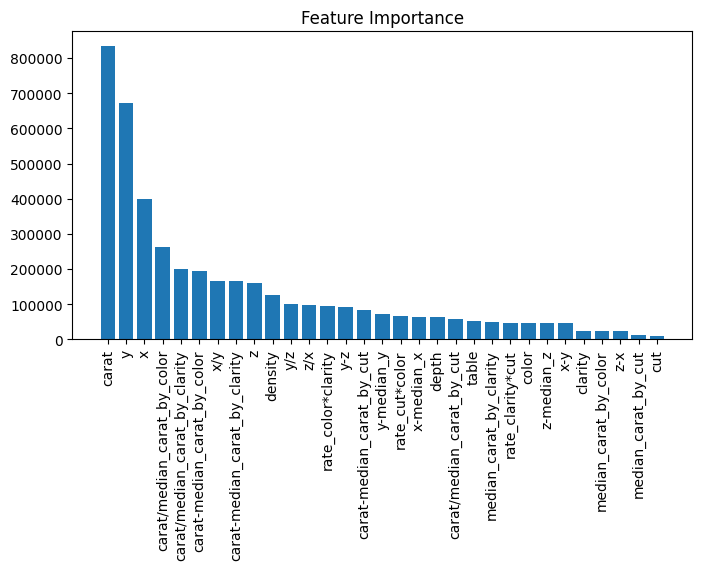

In [31]:
# 特徴量重要度の可視化
importances = model.feature_importance(importance_type='gain') # 特徴量重要度
indices = np.argsort(importances)[::-1] # 特徴量重要度を降順にソート

plt.figure(figsize=(8, 4)) #プロットのサイズ指定
plt.title('Feature Importance') # プロットのタイトルを作成
plt.bar(range(len(indices)), importances[indices]) # 棒グラフを追加
plt.xticks(range(len(indices)), X.columns[indices], rotation=90) # X軸に特徴量の名前を追加
plt.show() # プロットを表示

In [32]:
# 最適化ハイパーパラメータを用いたクロスバリデーション
from sklearn.model_selection import KFold

# 格納用データの作成
valid_scores = []
models = []
oof = np.zeros(len(X_train))

# KFoldを用いて学習データを5分割してモデルを作成
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train)):
    X_tr = X_train.iloc[tr_idx]
    X_va = X_train.iloc[va_idx]
    y_tr = y_train.iloc[tr_idx]
    y_va = y_train.iloc[va_idx]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)

    # 最適化ハイパーパラメータを読み込み
    model = lgb.train(params_best,
                      lgb_train,
                      num_boost_round=10000,
                      valid_sets=[lgb_train, lgb_eval],
                      valid_names=['train', 'valid'],
                      callbacks=[lgb.early_stopping(100),
                      lgb.log_evaluation(500)])

    y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
    score = mean_absolute_error(y_va, y_va_pred)
    print(f'fold {fold+1} MAE valid: {score:.2f}')
    print('')

    # スコア、モデル、予測値の格納
    valid_scores.append(score)
    models.append(model)
    oof[va_idx] = y_va_pred

# クロスバリデーションの平均スコア
cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score:.2f}')

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.208	valid's l1: 246.945
[1000]	train's l1: 188.225	valid's l1: 243.701
[1500]	train's l1: 171.646	valid's l1: 242.895
[2000]	train's l1: 160.111	valid's l1: 242.547
Early stopping, best iteration is:
[2040]	train's l1: 159.211	valid's l1: 242.467
fold 1 MAE valid: 242.47

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.135	valid's l1: 249.948
[1000]	train's l1: 186.858	valid's l1: 247.397
[1500]	train's l1: 170.77	valid's l1: 246.673
[2000]	train's l1: 159.432	valid's l1: 246.249
Early stopping, best iteration is:
[1909]	train's l1: 161.545	valid's l1: 246.184
fold 2 MAE valid: 246.18

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.045	valid's l1: 252.655
[1000]	train's l1: 186.551	valid's l1: 249.27
[1500]	train's l1: 169.25	valid's l1: 248.302
Early stopping, best iteration is:
[1767]	train's l1: 162.049	valid's l1: 247.896
fold 

In [33]:
# 検証データの誤差
valid_scores

[242.46710853571832,
 246.18436832184807,
 247.89640697210922,
 246.13335939684498,
 247.494448394561]

In [34]:
# 検証データの誤差平均
cv_score

246.03513832421632

In [35]:
# 検証データの誤差平均
print('MAE CV: %.2f' % (
      mean_absolute_error(y_train, oof)))

MAE CV: 246.04
